<a href="https://colab.research.google.com/github/johntiger1/hugging-face-generation/blob/master/Copy_of_t5_trivia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://colab.research.google.com/github/google-research/text-to-text-transfer-transformer/blob/master/notebooks/t5-trivia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The T5 Authors

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2019 The T5 Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Fine-Tuning the Text-To-Text Transfer Transformer (T5) for Closed-Book Question Answering
## _Or: What does T5 know?_

*The following tutorial guides you through the process of fine-tuning a pre-trained T5 model, evaluating its accuracy, and using it for prediction,
all on a free Google Cloud TPU <a href="https://colab.research.google.com/github/google-research/text-to-text-transfer-transformer/blob/master/notebooks/t5-trivia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>.*

### Background

T5 was introduced in the paper [_Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer_](https://arxiv.org/abs/1910.10683). In that paper, we provided a comprehensive picture of how we pre-trained a standard text-to-text Transformer model on a large text corpus, achieving state-of-the-art results on many NLP tasks after fine-tuning.

We pre-trained T5 on a mixture of supervised and unsupervised tasks with the majoriy of data coming from an unlabeled dataset we developed called [C4](https://www.tensorflow.org/datasets/catalog/c4). C4 is based on a massive scrape of the web produced by [Common Crawl](https://commoncrawl.org). Loosely speaking, pre-training on C4 ideally gives T5 an understanding of natural language in addition to general world knowledge.

### How can we assess what T5 knows?

As the name implies, T5 is a text-to-text model, which enables us to train it on arbitrary tasks involving a textual input and output. As we showed in our paper, a huge variety of NLP tasks can be cast in this format, including translation, summarization, and even classification and regression tasks.

One way to use this text-to-text framework is on reading comprehension problems, where the model is fed some context along with a question and is trained to predict the question's answer. For example, we might feed the model the text from the Wikipedia article about [Hurrican Connie](https://en.wikipedia.org/wiki/Hurricane_Connie) along with the question "On what date did Hurricane Connie occur?" and train the model to predict the answer "August 3rd, 1955".
A related task is open-domain question answering (QA) where the model is not provided with this oracle context. Typically, open-domain QA systems include a mechanism to look up information in an external knowledge source. This setting is similar to an "open-book" exam.

In this notebook, we'll be training T5 on a variant of this task which we call **closed-book question answering**. In closed-book QA, we feed the model a question *without any context or access to external knowledge* and train it to predict the answer. Since the model doesn't receive any context, the primary way it can learn to answer these questions is based on the "knowledge" it obtained during pre-training. We don't expect T5 to contain super specific information, so we will be focusing on two question-answering datasets which largely include trivia questions (i.e. facts about well-known subjects). [Similar](https://arxiv.org/abs/1909.01066) [investigations](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) have recently been done to test the knowledge stored by BERT and GPT-2.

T5 was not pre-trained on closed-book QA, so in this notebook we'll first create two new tasks and then use the [`t5`](https://github.com/google-research/text-to-text-transfer-transformer) library to fine-tune, evaluate, and obtain predictions from T5. In the end, T5's performance on closed-book QA can give us a sense of what kind (and how much) information T5 managed to learn during pre-training.

## State-of-the-art Results
We published a [more in-depth investigation](https://arxiv.org/abs/2002.08910) of closed-book QA with T5 where we achieved SOTA on open-domain variants of WebQuestions and TriviaQA in addition to surpisingly strong results on Natural Questions. The code in this notebook is a simplified version of those experiments but still produces good results.

For code to reproduce our best results, please see the [t5_closed_book_qa](https://github.com/google-research/google-research/tree/master/t5_closed_book_qa) repo.


### Caveats

* While we provide instructions for running on a [Cloud TPU](https://cloud.google.com/tpu/) via Colab for free, a [Google Cloud Storage (GCS)](http://console.cloud.google.com/storage) bucket is required for storing model parameters and data. The [GCS free tier](https://cloud.google.com/free/) provides 5 GB of storage, which should be enough to train the `large` model and smaller but not the `3B` or `11B` parameter models. You can use part of your initial $300 credit to get more space.
* The Cloud TPU provided by Colab (a `v2-8`) does not have enough memory to fine-tune the `11B` parameter model. For this model, you will need to fine-tune inside of a GCP instance (see [README](https://github.com/google-research/text-to-text-transfer-transformer/)).


# Set Up

<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Train on TPU</h3>




   1. Create a Cloud Storage bucket for your data and model checkpoints at http://console.cloud.google.com/storage, and fill in the `BASE_DIR` parameter in the following form. There is a [free tier](https://cloud.google.com/free/) if you do not yet have an account.
 
   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Run the following cell and follow instructions to:
    *  Set up a Colab TPU running environment
    *   Verify that you are connected to a TPU device
    *   Upload your credentials to TPU to access your GCS bucket


In [ ]:
print("Installing dependencies...")
# %tensorflow_version 2.1
!pip install t5==0.6.2

Installing dependencies...
     |████████████████████████████████| 163kB 3.3MB/s 
     |████████████████████████████████| 307kB 10.0MB/s 
     |████████████████████████████████| 1.1MB 16.9MB/s 
     |████████████████████████████████| 2.6MB 22.6MB/s 
     |████████████████████████████████| 3.5MB 38.8MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 778kB 41.3MB/s 
     |████████████████████████████████| 3.0MB 46.5MB/s 
     |████████████████████████████████| 890kB 46.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=fcf8dd4ec44ede23526e4a94f82f0a980efef42bd29047d64d8b65547ab6376d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:



import functools
import os
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds

import t5

BASE_DIR = "gs://t5-open-qa-bucket" #@param { type: "string" }
if not BASE_DIR or BASE_DIR == "gs://":
  raise ValueError("You must enter a BASE_DIR.")
DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
ON_CLOUD = True


if ON_CLOUD:
  print("Setting up GCS access...")
  import tensorflow_gcs_config
  from google.colab import auth
  # Set credentials for GCS reading/writing from Colab and TPU.
  TPU_TOPOLOGY = "2x2"
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    TPU_ADDRESS = tpu.get_master()
    print('Running on TPU:', TPU_ADDRESS)
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
  auth.authenticate_user()
  print("we are auth")
  tf.config.experimental_connect_to_host(TPU_ADDRESS)
  tensorflow_gcs_config.configure_gcs_from_colab_auth()

tf.disable_v2_behavior()

# Improve logging.
from contextlib import contextmanager
import logging as py_logging

if ON_CLOUD:
  tf.get_logger().propagate = False
  py_logging.root.setLevel('INFO')

@contextmanager
def tf_verbosity_level(level):
  og_level = tf.logging.get_verbosity()
  tf.logging.set_verbosity(level)
  yield
  tf.logging.set_verbosity(og_level)

INFO:tensorflow:tokens_length=568 inputs_length=512 targets_length=114 noise_density=0.15 mean_noise_span_length=3.0 
Setting up GCS access...
Running on TPU: grpc://10.49.222.226:8470
we are auth
Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import tensorflow

In [ ]:
tensorflow.__version__

'2.3.0'

# Creating new Tasks and Mixture

Two core components of the T5 library are `Task` and `Mixture` objects.

A `Task` is a dataset along with preprocessing functions and evaluation metrics. A `Mixture` is a collection of `Task` objects along with a mixing rate or a function defining how to compute a mixing rate based on the properties of the constituent `Tasks`.

For this example, we will fine-tune the model to do closed-book question answering.

### Natural Questions

[Natural Questions (NQ)](https://ai.google.com/research/NaturalQuestions) is a challenging corpus for open-domain QA. Each example includes a question along with an entire Wikipedia article that may or may not contain its answer. The goal is to produce the correct answer given this context. In our case, we will be ignoring the provided context in hopes that the model will learn to find the answers from the world knowledge it has acquired during pre-training.

Since the raw data splits are stored as JSONL files, we will first need to convert them to TSV format to make them parseable in TensorFlow. We will also take the opportunity to drop information we will not be using, remove questions with multiple answers, and to do a bit of cleaning of the text.

In [ ]:
import gzip
import json

# Public directory of Natural Questions data on GCS.
NQ_JSONL_DIR = "gs://natural_questions/v1.0-simplified/"
NQ_SPLIT_FNAMES = {
    "train": "simplified-nq-train.jsonl.gz",
    "validation": "nq-dev-all.jsonl.gz"
}
nq_counts_path = os.path.join(DATA_DIR, "nq-counts.json")
nq_tsv_path = {
    "train": os.path.join(DATA_DIR, "nq-train.tsv"),
    "validation": os.path.join(DATA_DIR, "nq-validation.tsv")
}

covid_qa_tsv_path = {
    "train": os.path.join(DATA_DIR, "cleaned-covid-train.tsv"),
    "validation": os.path.join(DATA_DIR, "cleaned-covid-valid.tsv")

}

import pandas as pd
def csv_to_tsv(in_fname, out_fname):
  my_df = pd.load_csv(in_fname)

  

'''
We need to redo it:
formulate the COVID-19 in this format
'''
from tqdm.auto import tqdm
def nq_jsonl_to_tsv(in_fname, out_fname):

  def extract_answer(tokens, span):
    """Reconstruct answer from token span and remove extra spaces."""
    start, end = span["start_token"], span["end_token"]  
    ans = " ".join(tokens[start:end])
    # Remove incorrect spacing around punctuation.
    ans = ans.replace(" ,", ",").replace(" .", ".").replace(" %", "%")
    ans = ans.replace(" - ", "-").replace(" : ", ":").replace(" / ", "/")
    ans = ans.replace("( ", "(").replace(" )", ")")
    ans = ans.replace("`` ", "\"").replace(" ''", "\"")
    ans = ans.replace(" 's", "'s").replace("s ' ", "s' ")
    return ans

  count = 0
  with tf.io.gfile.GFile(in_fname, "rb") as infile,\
       tf.io.gfile.GFile(out_fname, "w") as outfile:
    for line in tqdm(gzip.open(infile)):
      ex = json.loads(line)
      # Remove any examples with more than one answer.
      if len(ex['annotations'][0]['short_answers']) != 1:
        continue
      # Questions in NQ do not include a question mark.
      question = ex["question_text"] + "?"
      answer_span = ex['annotations'][0]['short_answers'][0]
      # Handle the two document formats in NQ (tokens or text).
      if "document_tokens" in ex:
        tokens = [t["token"] for t in ex["document_tokens"]]
      elif "document_text" in ex:
        tokens = ex["document_text"].split(" ")
      answer = extract_answer(tokens, answer_span)
      # Write this line as <question>\t<answer>
      outfile.write("%s\t%s\n" % (question, answer)) # we just need Q TAB A pairs
      count += 1
      tf.logging.log_every_n(
          tf.logging.INFO,
          "Wrote %d examples to %s." % (count, out_fname),
          1000)
      # if count > 100 and count % 10000 == 0:
      #   print("nice, finsihed 10k examples")
      #   break
    return count

if tf.io.gfile.exists(nq_counts_path):
  # Used cached data and counts.
  tf.logging.info("Loading NQ from cache.")
  num_nq_examples = json.load(tf.io.gfile.GFile(nq_counts_path))
else:
  # Create TSVs and get counts.
  tf.logging.info("Generating NQ TSVs.")
  num_nq_examples = {}
  for split, fname in NQ_SPLIT_FNAMES.items():
    num_nq_examples[split] = nq_jsonl_to_tsv(
        os.path.join(NQ_JSONL_DIR, fname), nq_tsv_path[split])
  json.dump(num_nq_examples, tf.io.gfile.GFile(nq_counts_path, "w"))

INFO:tensorflow:Loading NQ from cache.


In [ ]:
num_nq_examples

{'train': 96499, 'validation': 2338}

In [ ]:
pip install gcsfs

In [ ]:
DATA_DIR

'gs://t5-open-qa-bucket/data'

In [ ]:
import pandas as pd


In [ ]:
my_df = pd.read_csv(os.path.join(DATA_DIR,"cleaned_QA_COVID_19_General.csv"))


In [ ]:
my_df

,question,text,answer
0,What is a coronavirus?,Coronaviruses are a large family of viruses wh...,a large family of viruses
1,what is COVID-19?,COVID-19 is the infectious disease caused by t...,infectious disease
2,what are the symptoms of COVID-19?,The most common symptoms of COVID-19 are fever...,"fever, tiredness, and dry cough"
3,How does COVID-19 spread?,People can catch COVID-19 from others who have...,spread from person to person through small dro...
4,How likely am I to catch COVID-19?,The risk depends on where you are - and more ...,in most locations the risk of catching COVID-1...
...,...,...,...
192,\nHow does the virus spread?,Officials are still learning about how COVID-1...,"From touching our mouths, noses or eyes after ..."
193,How does the virus spread?,Officials are still learning about how COVID-1...,From close contact with people who have it.\n
194,How does the virus spread?,Officials are still learning about how COVID-1...,From respiratory droplets that become airborne...
195,\nWill warm weather stop the outbreak of COVID...,Researchers are still learning about how easil...,it’s unclear


In [ ]:
my_df.dtypes

question    object
text        object
answer      object
dtype: object

In [ ]:
my_df = my_df.astype(pd.StringDtype())

In [ ]:
my_df.dtypes

question    string
text        string
answer      string
dtype: object

In [ ]:

relevant_df = my_df[["question", "answer"]].dropna()

In [ ]:
len(relevant_df)

178

In [ ]:
# relevant_df.iloc[432,1]

In [ ]:
# incredibly, some of them are floats!!
relevant_df["question"] = relevant_df["question"].map(lambda x: x.replace("\n", " "))
relevant_df["answer"] = relevant_df["answer"].map(lambda x: x.replace("\n", " "))




In [ ]:
my_df.dtypes

question    string
text        string
answer      string
dtype: object

In [ ]:
relevant_df

,question,answer
0,What is a coronavirus?,a large family of viruses
1,what is COVID-19?,infectious disease
2,what are the symptoms of COVID-19?,"fever, tiredness, and dry cough"
3,How does COVID-19 spread?,spread from person to person through small dro...
4,How likely am I to catch COVID-19?,in most locations the risk of catching COVID-1...
...,...,...
192,How does the virus spread?,"From touching our mouths, noses or eyes after ..."
193,How does the virus spread?,From close contact with people who have it.
194,How does the virus spread?,From respiratory droplets that become airborne...
195,Will warm weather stop the outbreak of COVID-19?,it’s unclear


In [ ]:
len(relevant_df["question"].unique())


170

In [ ]:
relevant_df.groupby("question").count().sort_values(by="answer", ascending=False)

,answer
question,
How can I protect myself from getting COVID-19?,7
How can I ask for help?,2
How does the virus spread?,2
Are there any tests that I can purchase to test myself at home for COVID-19?,1
"What happens if a pregnant worker is exposed to COVID-19 while on reassignment in a healthcare setting, including a dedicated COVID-19 clinic?",1
...,...
How long will the results take?,1
How must the employer verify the state of health of the workers arriving on the work site?,1
How should I clean my environment?,1


In [ ]:

len(relevant_df.groupby("question").count().sort_values(by="answer", ascending=False))

170

In [ ]:
type(relevant_df.groupby("question").count().sort_values(by="answer", ascending=False))

pandas.core.frame.DataFrame

In [ ]:
isinstance(relevant_df.groupby("question").count().sort_values(by="answer", ascending=False), pd.DataFrame)

True

In [ ]:
relevant_df.groupby("question").count().sort_values(by="answer", ascending=False).index # the index is now over questions 

Index(['How can I protect myself from getting COVID-19?',
       'How can I ask for help?', 'How does the virus spread?',
       ' Are there any tests that I can purchase to test myself at home for COVID-19?',
       'What happens if a pregnant worker is exposed to COVID-19 while on reassignment in a healthcare setting, including a dedicated COVID-19 clinic?',
       'What can I do to help those who are vulnerable in Oxford?',
       'What can National Veterinary Services do with regards to companion animals?',
       'What do I do if my workplace first aid card expires?',
       'What does it really mean to self-isolate or self-quarantine? What should or shouldn't I do?',
       'What does the CNESST suggest for my employer, who has arranged a medical assessment?',
       ...
       'How does COVID-19 spread?',
       'How does the CNESST intervene in the case of a priority or non-priority business?',
       'How does the testing work?', 'How likely am I to catch COVID-19?',
       'H

In [ ]:
grouped_questions_df = relevant_df.groupby("question").count().sort_values(by="answer", ascending=False)

In [ ]:
# (relevant_df.groupby("question").count().sort_values(by="answer", ascending=False)) == pd.DataFrame

In [ ]:
# Ensure that repeated questions are dumped in the same split
# to do this, we simply need to split up everything , and assign labels too. Give the indexes to the appropriate people.
# let's handroll it and see what happens!! 
import numpy as np

In [ ]:
np.random.binomial(1, 0.05, size=(len(grouped_questions_df))) # want K binomial samples

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
samples = np.random.binomial(1, 0.05, size=(len(grouped_questions_df))) 

In [ ]:
samples_df = pd.DataFrame(samples, columns=["test"])

In [ ]:
samples_df

,test
0,0
1,0
2,0
3,0
4,0
...,...
165,0
166,0
167,0
168,0


In [ ]:
grouped_questions_df

,answer
question,
How can I protect myself from getting COVID-19?,7
How can I ask for help?,2
How does the virus spread?,2
Are there any tests that I can purchase to test myself at home for COVID-19?,1
"What happens if a pregnant worker is exposed to COVID-19 while on reassignment in a healthcare setting, including a dedicated COVID-19 clinic?",1
...,...
How long will the results take?,1
How must the employer verify the state of health of the workers arriving on the work site?,1
How should I clean my environment?,1


In [ ]:
unique_questions_df = grouped_questions_df.reset_index()

In [ ]:
unique_questions_df

,question,answer
0,How can I protect myself from getting COVID-19?,7
1,How can I ask for help?,2
2,How does the virus spread?,2
3,Are there any tests that I can purchase to te...,1
4,What happens if a pregnant worker is exposed t...,1
...,...,...
165,How long will the results take?,1
166,How must the employer verify the state of heal...,1
167,How should I clean my environment?,1
168,"How to put on, use,take off and dispose of a m...",1


In [ ]:
# now, concat things, and then select the df based on them. Will require one last final join too
pd.concat((unique_questions_df,samples_df), axis=1)

,question,answer,test
0,How can I protect myself from getting COVID-19?,7,0
1,How can I ask for help?,2,0
2,How does the virus spread?,2,0
3,Are there any tests that I can purchase to te...,1,0
4,What happens if a pregnant worker is exposed t...,1,0
...,...,...,...
165,How long will the results take?,1,0
166,How must the employer verify the state of heal...,1,0
167,How should I clean my environment?,1,0
168,"How to put on, use,take off and dispose of a m...",1,0


In [ ]:
assignments_df = pd.concat((unique_questions_df,samples_df), axis=1).drop(["answer"], axis=1)


In [ ]:
# assignments_df.drop(["answer"], axis=1)

In [ ]:
expanded_assignments_df = relevant_df.merge(assignments_df, left_on=["question"], right_on=["question"], how="inner") 

In [ ]:
expanded_assignments_df["test"].describe()

count    178.000000
mean       0.050562
std        0.219719
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: test, dtype: float64

In [ ]:
expanded_assignments_df.groupby(["question", "test"]).count().sort_values(by="answer", ascending=False)

,,answer
question,test,
How can I protect myself from getting COVID-19?,0,7
How can I ask for help?,0,2
How does the virus spread?,0,2
Are there any tests that I can purchase to test myself at home for COVID-19?,0,1
"What happens if a pregnant worker is exposed to COVID-19 while on reassignment in a healthcare setting, including a dedicated COVID-19 clinic?",0,1
...,...,...
How long will the results take?,0,1
How must the employer verify the state of health of the workers arriving on the work site?,0,1
How should I clean my environment?,0,1


In [ ]:
expanded_assignments_df.groupby(["question"]).agg("sum").sort_values(by="test",ascending=False)

,test
question,
Is the antiviral drug remdesivir effective for treating COVID-19?,1
why test?,1
How did the first human SARS-CoV-2 infections occcur?,1
Could the arrival of spring and the warmer weather affect the spread of COVID-19?,1
What types of medications and health supplies should I have on hand for an extended stay at home?,1
...,...
How long will the results take?,0
How must the employer verify the state of health of the workers arriving on the work site?,0
How should I clean my environment?,0


In [ ]:
unique_train_df = expanded_assignments_df[expanded_assignments_df["test"]==0].drop("test",axis=1)

In [ ]:
unique_test_df = expanded_assignments_df[expanded_assignments_df["test"]==1].drop("test",axis=1)


In [ ]:
unique_test_df

,question,answer
18,How did the first human SARS-CoV-2 infections ...,it is not possible to determine precisely how ...
37,why test?,testing can confirm an infection
46,Could the arrival of spring and the warmer wea...,"It might, but so far COVID-19 has been found i..."
65,Is the antiviral drug remdesivir effective for...,evidence from laboratory and animal studies su...
125,Will the 30-day deadline for supplementary rep...,"Yes, the CNESST is extending the deadline for ..."
136,What are the Veterinary Authority’s internatio...,remain informed and maintain close liaison wit...
146,What does it really mean to self-isolate or se...,Stay home except to get medical care
147,What types of medications and health supplies ...,Medical and health supplies
172,What is the source of the virus now affecting...,"spread from animals to people, and from people..."


In [ ]:
unique_train_df.groupby("question").count().sort_values(by="answer")

,answer
question,
Are there any tests that I can purchase to test myself at home for COVID-19?,1
What are the new tests coming?,1
What are the preventive measures to be implemented during work on a contaminated site?,1
What are the steps for a pregnant worker to apply for reassignment due to the coronavirus?,1
What can I do if I do not receive a record of employment or termination of employment?,1
...,...
How do we know if a vaccine is likely to work?,1
What are the measures to be implemented on construction sites to reduce contamination linked to COVID-19?,1
How can I ask for help?,2


In [ ]:
len(unique_test_df)

9

In [ ]:
unique_train_df.to_csv(os.path.join(DATA_DIR,"cleaned-covid-train.tsv"),sep="\t",index=False, header=False)

In [ ]:
unique_test_df.to_csv(os.path.join(DATA_DIR,"cleaned-covid-valid.tsv"),sep="\t",index=False, header=False)

In [ ]:
# np.random.uniform(1, 0.05, size=(len(grouped_questions_df))) # 

In [ ]:
# from sklearn.model_selection import train_test_split
# # randchoice k indices without replacement
# train_covid_df, valid_covid_df = train_test_split(relevant_df, test_size=0.05, random_state=0)

In [ ]:
NUM_COVID_EXAMPLES = {"train":len(unique_train_df), "validation":len(unique_test_df)}

In [ ]:
NUM_COVID_EXAMPLES

{'train': 169, 'validation': 9}

In [ ]:
# with open(os.path.join(DATA_DIR,"abc.txt"), "w") as file:
#   file.write("hello\n")

with open("my_file.txt", "w") as file:
  file.write("akf\n")

In [ ]:
# with tf.io.gfile.GFile(os.path.join(DATA_DIR,"abc.txt"), "w") as file:
#   file.write("hello\n")


In [ ]:
# with tf.io.gfile.GFile(covid_qa_tsv_path["train"], "r") as file:
#   for line in file:
#     print(line)

Next, we define a function to load the TSV data as a `tf.data.Dataset` in TensorFlow.

In [ ]:
def nq_dataset_fn(split, shuffle_files=False):
  # We only have one file for each split.
  del shuffle_files

  # Load lines from the text file as examples.
  ds = tf.data.TextLineDataset(nq_tsv_path[split]) #add in the specific examples you want here as well 
  # Split each "<question>\t<answer>" example into (question, answer) tuple.
  ds = ds.map(
      functools.partial(tf.io.decode_csv, record_defaults=["", ""],
                        field_delim="\t", use_quote_delim=False),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # Map each tuple to a {"question": ... "answer": ...} dict.
  ds = ds.map(lambda *ex: dict(zip(["question", "answer"], ex)))
  return ds

print("A few raw validation examples...")
for ex in tfds.as_numpy(nq_dataset_fn("validation").take(1)):
  # print(ex)
  print(len(ex))
  # print(ex["question"])
  # print(ex["answer"])

A few raw validation examples...
2


In [ ]:
covid_qa_tsv_path

{'train': 'gs://t5-open-qa-bucket/data/cleaned-covid-train.tsv',
 'validation': 'gs://t5-open-qa-bucket/data/cleaned-covid-valid.tsv'}

In [ ]:
def covid_dataset_fn(split, shuffle_files=False):
  # We only have one file for each split.
  del shuffle_files

  # Load lines from the text file as examples.
  ds = tf.data.TextLineDataset(covid_qa_tsv_path[split]) #add in the specific examples you want here as well 
  # Split each "<question>\t<answer>" example into (question, answer) tuple.
  ds = ds.map(
      functools.partial(tf.io.decode_csv, record_defaults=["", ""],
                        field_delim="\t", use_quote_delim=False),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # Map each tuple to a {"question": ... "answer": ...} dict.
  ds = ds.map(lambda *ex: dict(zip(["question", "answer"], ex)))
  
  return ds

print("A few raw validation examples...")
for ex in tfds.as_numpy(covid_dataset_fn("train").take(5)):
  # print(ex)
  print(len(ex))
  # print(ex["question"])
  # print(ex["answer"])


A few raw validation examples...
2
2
2
2
2


In [ ]:
train_ds = covid_dataset_fn("train")

In [ ]:
# # tf.compat.v1.enable_eager_execution()

# with tf.session() as sess:
#   for ex in test_ds:
#     print(ex)

Now, we write a preprocess function to convert the examples in the `tf.data.Dataset` into a text-to-text format, with both `inputs` and `targets` fields. The preprocessor also normalizes the text by lowercasing it and removing quotes since the answers are sometimes formatted in odd ways. Finally, we prepend 'trivia question:' to the inputs so that the model knows what task it's trying to solve.

In [ ]:
def trivia_preprocessor(ds):
  def normalize_text(text):
    """Lowercase and remove quotes from a TensorFlow string."""
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text,"'(.*)'", r"\1")
    return text

  def to_inputs_and_targets(ex):
    """Map {"question": ..., "answer": ...}->{"inputs": ..., "targets": ...}."""
    return {
        "inputs":
             tf.strings.join(
                 ["trivia question: ", normalize_text(ex["question"])]),
        "targets": normalize_text(ex["answer"])
    }
  return ds.map(to_inputs_and_targets, 
                num_parallel_calls=tf.data.experimental.AUTOTUNE)

Finally, we put everything together to create a `Task`.

In [ ]:
t5.data.TaskRegistry.add(
    "nq_context_free",
    # Supply a function which returns a tf.data.Dataset.
    dataset_fn=nq_dataset_fn,
    splits=["train", "validation"],
    # Supply a function which preprocesses text from the tf.data.Dataset.
    text_preprocessor=[trivia_preprocessor],
    # Lowercase targets before computing metrics.
    postprocess_fn=t5.data.postprocessors.lower_text, 
    # We'll use accuracy as our evaluation metric.
    metric_fns=[t5.evaluation.metrics.accuracy],
    # Not required, but helps for mixing and auto-caching.
    num_input_examples=num_nq_examples
)

Let's look at a few pre-processed examples from the validation set. Note they contain both the tokenized (integer) and plain-text inputs and targets.


In [ ]:
nq_task = t5.data.TaskRegistry.get("nq_context_free")
ds = nq_task.get_dataset(split="validation", sequence_length={"inputs": 128, "targets": 32})
print("A few preprocessed validation examples...")
for ex in tfds.as_numpy(ds.take(5)):
  print(ex)

/usr/local/lib/python3.6/dist-packages/t5/data/utils.py:273: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return dataset.map(my_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)


A few preprocessed validation examples...
{'inputs_plaintext': b'trivia question: who played john clark sr on nypd blue?', 'inputs': array([22377,   822,    10,   113,  1944,     3, 27341,  6860,   157,
           3,     7,    52,    30,     3,    29,    63,   102,    26,
        1692,    58,     1]), 'targets_plaintext': b'joe spano', 'targets': array([   3, 1927,   15, 8438,   32,    1])}
{'inputs_plaintext': b'trivia question: what nfl team is robert griffin the third playing for?', 'inputs': array([22377,   822,    10,   125,     3,    29,    89,    40,   372,
          19,     3,  5840,    49,    17,     3, 11442,    77,     8,
        1025,  1556,    21,    58,     1]), 'targets_plaintext': b'currently a free agent', 'targets': array([1083,    3,    9,  339, 3102,    1])}
{'inputs_plaintext': b'trivia question: where does kfc get their chicken in south africa?', 'inputs': array([22377,   822,    10,   213,   405,     3,   157,    89,    75,
         129,    70,  3832,    16,  341

**Note**: Instead of defining `nq_dataset_fn` and above, we also could have used the `TextLineTask` class with the `parse_tsv` preprocessor for equivalent results as follows:

```py
t5.data.TaskRegistry.add(
    "nq_context_free",
    t5.data.TextLineTask,
    split_to_filepattern=nq_tsv_path,
    text_preprocessor=[
      functools.partial(
          t5.data.preprocessors.parse_tsv,
          field_names=["question", "answer"]),
      trivia_preprocessor
    ],
    postprocess_fn=t5.data.postprocessors.lower_text, 
    metric_fns=[t5.evaluation.metrics.accuracy],
    num_input_examples=num_nq_examples
)
```


In [ ]:
t5.data.TaskRegistry.remove("covid_context_free")

In [ ]:
t5.data.TaskRegistry.add(
    "covid_context_free",
    # Supply a function which returns a tf.data.Dataset.
    dataset_fn=covid_dataset_fn,
    splits=["train", "validation"],
    # Supply a function which preprocesses text from the tf.data.Dataset.
    text_preprocessor=[trivia_preprocessor],
    # Lowercase targets before computing metrics.
    postprocess_fn=t5.data.postprocessors.lower_text, 
    # We'll use accuracy as our evaluation metric.
    metric_fns=[t5.evaluation.metrics.accuracy],
    # Not required, but helps for mixing and auto-caching.
    num_input_examples=NUM_COVID_EXAMPLES
)

In [ ]:
covid_qa_task = t5.data.TaskRegistry.get("covid_context_free")
covid_ds = covid_qa_task.get_dataset(split="validation", sequence_length={"inputs": 128, "targets": 32})
print("A few preprocessed validation examples...")
for ex in tfds.as_numpy(covid_ds.take(5)):
  print(ex)

/usr/local/lib/python3.6/dist-packages/t5/data/utils.py:273: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return dataset.map(my_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)


A few preprocessed validation examples...
{'inputs_plaintext': b'trivia question: will the 30-day deadline for supplementary reports be extended for attending physicians?', 'inputs': array([22377,   822,    10,    56,     8, 12471,  1135,  7183,    21,
           3, 31505,  2279,    36,  4760,    21,  7078, 13768,    58,
           1]), 'targets_plaintext': b'yes, the cnesst is extending the deadline for submitting supplementary reports by 30 days during the covid-19 pandemic', 'targets': array([ 4273,     6,     8,     3,    75,   655,    17,    19,     3,
       16878,     8,  7183,    21,     3, 14975,     3, 31505,  2279,
          57,   604,   477,   383,     8,   576,  6961,  4481,  2131,
         221,  3113,     1])}
{'inputs_plaintext': b'trivia question: how did the first human sars-cov-2 infections occcur?', 'inputs': array([22377,   822,    10,   149,   410,     8,   166,   936,     3,
           7,   291,     7,    18, 16745,  4949, 13315,     3, 13377,
        3663,    58,

## TriviaQA

A second dataset we will use is related to [TriviaQA](https://nlp.cs.washington.edu/triviaqa/). It is also intended for reading comprehension, but, once again, we will modify the task here by ignoring the provided context.

Since the dataset has been imported into [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/catalog/trivia_qa), we can let it handle the data parsing for us. It will take a few minutes to download and preprocess the first time, but we'll be able to access it instantly from our data directory afterward.

In [ ]:
ds = tfds.load(
    "trivia_qa/unfiltered.nocontext",
    data_dir=DATA_DIR,
    # Download data locally for preprocessing to avoid using GCS space.
    download_and_prepare_kwargs={"download_dir": "./downloads"})
print("A few raw validation examples...")
for ex in tfds.as_numpy(ds["validation"].take(2)):
  print(ex)

INFO:absl:Load dataset info from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0
INFO:absl:Reusing dataset trivia_qa (gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0)
INFO:absl:Constructing tf.data.Dataset for split None, from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0


A few raw validation examples...
{'answer': {'aliases': array([b'Torquemada (disambiguation)', b'Torquemada'], dtype=object), 'matched_wiki_entity_name': b'', 'normalized_aliases': array([b'torquemada', b'torquemada disambiguation'], dtype=object), 'normalized_matched_wiki_entity_name': b'', 'normalized_value': b'torquemada', 'type': b'WikipediaEntity', 'value': b'Torquemada'}, 'entity_pages': {'doc_source': array([], dtype=object), 'filename': array([], dtype=object), 'title': array([], dtype=object), 'wiki_context': array([], dtype=object)}, 'question': b'In 1483, who was appointed the first grand inquisitor of the Spanish Inquisition?', 'question_id': b'qw_16011', 'question_source': b'http://www.quizwise.com/', 'search_results': {'description': array([], dtype=object), 'filename': array([], dtype=object), 'rank': array([], dtype=int32), 'search_context': array([], dtype=object), 'title': array([], dtype=object), 'url': array([], dtype=object)}}
{'answer': {'aliases': array([b'Auster

As with Natural Questions, we need to preprocess the raw examples into `inputs` and `targets` features. We can reuse the `trivia_preprocessor` above, but first we need to convert the TriviaQA examples into the correct format, ignoring the fields we don't need for our task.

We'll then define our `Task` and print out a few preprocessed examples from the validation set.

Note that we do not need to specify the splits or number of examples since that information is provided by TFDS.

In [ ]:
def tiviaqa_extract_qa(ds):
  def exract_qa(ex):
    return {
        "question": ex["question"],
        "answer": ex["answer"]["value"]
    }
  return ds.map(exract_qa, num_parallel_calls=tf.data.experimental.AUTOTUNE)

t5.data.TaskRegistry.add(
    "triviaqa_context_free",
    # A TfdsTask takes in a TFDS name instead of a tf.data.Dataset function.
    t5.data.TfdsTask,
    tfds_name="trivia_qa/unfiltered.nocontext:1.1.0",
    tfds_data_dir=DATA_DIR,
    text_preprocessor=[tiviaqa_extract_qa, trivia_preprocessor],
    postprocess_fn=t5.data.postprocessors.lower_text,
    metric_fns=[t5.evaluation.metrics.accuracy]
)

# Load and print a few examples.
triviaqa_task = t5.data.TaskRegistry.get("triviaqa_context_free")
ds = triviaqa_task.get_dataset(split="validation", sequence_length={"inputs": 128, "targets": 32})
print("A few preprocessed validation examples...")
for ex in tfds.as_numpy(ds.take(3)):
  print(ex)

INFO:absl:Load dataset info from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0
INFO:absl:Reusing dataset trivia_qa (gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0)
INFO:absl:Constructing tf.data.Dataset for split validation, from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0
/usr/local/lib/python3.6/dist-packages/t5/data/utils.py:273: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return dataset.map(my_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
INFO:absl:Load dataset info from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0


A few preprocessed validation examples...
{'inputs_plaintext': b'trivia question: what is more likely to be associated with a sward?', 'inputs': array([22377,   822,    10,   125,    19,    72,   952,    12,    36,
        1968,    28,     3,     9,     3,     7,  2239,    58,     1]), 'targets_plaintext': b'chewings fescue', 'targets': array([15196,    53,     7,     3,    89,  5152,    15,     1])}
{'inputs_plaintext': b'trivia question: which serbian football club is the only one from that country to win an uefa completion?', 'inputs': array([22377,   822,    10,    84,  7637, 12032,  3370,  1886,    19,
           8,   163,    80,    45,    24,   684,    12,  1369,    46,
           3,    76,    15,    89,     9,  6929,    58,     1]), 'targets_plaintext': b'red star belgrade', 'targets': array([1131, 2213,   36,   40, 6801,    1])}
{'inputs_plaintext': b'trivia question: the left side of the heart pumps blood to all parts of the body, but the right side pumps blood to which organ 

## Dataset Mixture

We now create a `Mixture` from the above `Tasks`, which we will fine-tune on.

There are different ways to automatically set the rate (for example, based on the number of examples using `rate_num_examples`), but we will just hardcode an equal mixture for simplicity.

In [ ]:
t5.data.MixtureRegistry.remove("trivia_all")
t5.data.MixtureRegistry.add(
    "trivia_all",
    ["nq_context_free", "triviaqa_context_free", "covid_context_free"],
     default_rate=1.0
)

# Transferring to new Tasks

We are now ready to fine-tune one of the pre-trained T5 models on our new mixture of closed-book QA tasks.

First, we'll instantiate a `Model` object using the model size of your choice. Note that larger models are slower to train and use but will likely achieve higher accuracy. You also may be able to increase accuracy by training longer with more `FINETUNE_STEPS` below.


## Caveats

* Due to its memory requirements, you will not be able to train the `11B` parameter model on the TPU provided by Colab. Instead, you will need to fine-tune inside of a GCP instance (see [README](https://github.com/google-research/text-to-text-transfer-transformer/)).
* Due to the checkpoint size, you will not be able use the 5GB GCS free tier for the `3B` parameter models. You will need at least 25GB of space, which you can purchase with your $300 of initial credit on GCP.
* While `large` can achieve decent results, it is recommended that you fine-tune at least the `3B` parameter model.


## Define Model

In [ ]:
MODEL_SIZE = "large" #@param["small", "base", "large", "3B", "11B"]
# Public GCS path for T5 pre-trained model checkpoints
BASE_PRETRAINED_DIR = "gs://t5-data/pretrained_models"
PRETRAINED_DIR = os.path.join(BASE_PRETRAINED_DIR, MODEL_SIZE)
MODEL_DIR = os.path.join(MODELS_DIR, MODEL_SIZE)

if ON_CLOUD and MODEL_SIZE == "3B":
  tf.logging.warn(
      "The `3B` model is too large to use with the 5GB GCS free tier. "
      "Make sure you have at least 25GB on GCS before continuing."
  )
elif ON_CLOUD and MODEL_SIZE == "11B":
  raise ValueError(
      "The `11B` parameter is too large to fine-tune on the `v2-8` TPU "
      "provided by Colab. Please comment out this Error if you're running "
      "on a larger TPU."
  )

# Set parallelism and batch size to fit on v2-8 TPU (if possible).
# Limit number of checkpoints to fit within 5GB (if possible).
model_parallelism, train_batch_size, keep_checkpoint_max = {
    "small": (1, 256, 16),
    "base": (2, 128, 8),
    "large": (8, 64, 4),
    "3B": (8, 16, 1),
    "11B": (8, 16, 1)}[MODEL_SIZE]

tf.io.gfile.makedirs(MODEL_DIR)
# The models from our paper are based on the Mesh Tensorflow Transformer.
model = t5.models.MtfModel(
    model_dir=MODEL_DIR,
    tpu=TPU_ADDRESS,
    tpu_topology=TPU_TOPOLOGY,
    model_parallelism=model_parallelism,
    batch_size=train_batch_size,
    sequence_length={"inputs": 128, "targets": 32},
    learning_rate_schedule=0.003,
    save_checkpoints_steps=5000,
    keep_checkpoint_max=keep_checkpoint_max if ON_CLOUD else None,
    iterations_per_loop=100,
)

Before we continue, let's load a [TensorBoard](https://www.tensorflow.org/tensorboard) visualizer so that we can keep monitor our progress. The page should automatically update as fine-tuning and evaluation proceed.

In [ ]:
# if ON_CLOUD:
#   %reload_ext tensorboard
#   import tensorboard as tb
# tb.notebook.start("--logdir " + MODELS_DIR)

## Fine-tune

We are now ready to fine-tune our model. This will take a while (~2 hours with default settings), so please be patient! The larger the model and more `FINETUNE_STEPS` you use, the longer it will take.

Don't worry, you can always come back later and increase the number of steps, and it will automatically pick up where you left off.

In [ ]:
FINETUNE_STEPS =  25000#@param {type: "integer"}

model.finetune(
    mixture_or_task_name="trivia_all",
    pretrained_model_dir=PRETRAINED_DIR,
    finetune_steps=FINETUNE_STEPS
)

INFO:tensorflow:Using config: {'_model_dir': 'gs://t5-open-qa-bucket/models/large', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.49.222.226:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['10.49.222.226:8470']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.49.222.226:8470', '_evaluation_master': 'grpc://10.49.222.226:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_rep

In [ ]:
model

## Expected Results [SPOILER ALERT]

Below are the expected accuracies on the Natural Question (NQ) and TriviQA validation sets for various model sizes. The full 11B model produces the exact text of the answer 34.5% and 25.1% of the time on TriviaQA and NQ, respectively. The 3B parameter model, which is the largest that can be trained with a free Cloud TPU in Colab, achieves 29.7% and 23.7%, respectively.

In reality, the model performs better than this since requiring exact match is too strict of a metric, as you’ll see in the examples below. This helps to explain why the model appears to perform better on TriviaQA than NQ, as the latter tends to include more long-form answers extracted from the context.

Please see our [paper on closed-book QA](https://tiny.cc/t5-qa) where achieved even better results.

<img src="https://storage.googleapis.com/t5-data/assets/t5_trivia_expected.png">

## Evaluate

We now evaluate on the validation sets of the tasks in our mixture. Accuracy results will be logged and added to the TensorBoard above.

In [ ]:
# Use a larger batch size for evaluation, which requires less memory.
model.batch_size = train_batch_size * 4
model.eval(
    mixture_or_task_name="trivia_all",
    checkpoint_steps="all"
)

INFO:tensorflow:Using config: {'_model_dir': 'gs://t5-open-qa-bucket/models/large', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.49.222.226:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['10.49.222.226:8470']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.49.222.226:8470', '_evaluation_master': 'grpc://10.49.222.226:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_rep

/usr/local/lib/python3.6/dist-packages/t5/data/utils.py:273: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return dataset.map(my_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
INFO:absl:Load dataset info from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0
INFO:absl:Reusing dataset trivia_qa (gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0)
INFO:absl:Constructing tf.data.Dataset for split validation, from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0


INFO:tensorflow:Checkpoint path gs://t5-open-qa-bucket/models/large/model.ckpt-1010900
INFO:tensorflow:Querying Tensorflow master (grpc://10.49.222.226:8470) for TPU system metadata.
INFO:tensorflow:Initializing TPU system (master: grpc://10.49.222.226:8470) to fetch topology for model parallelism. This might take a while.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 5423937064603129413)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, -4997269170137918583)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, -1828807718858584162)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 171798

INFO:absl:Load dataset info from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0
INFO:absl:Reusing dataset trivia_qa (gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0)
INFO:absl:Constructing tf.data.Dataset for split validation, from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0


INFO:tensorflow:num_cores_per_replica: 1
INFO:tensorflow:computation_shape: [1, 1, 1, 1]
INFO:tensorflow:num_replicas: 8
INFO:tensorflow:device_assignment.topology.device_coordinates: [[[0 0 0 0]
  [0 0 0 1]
  [1 0 0 0]
  [1 0 0 1]
  [0 1 0 0]
  [0 1 0 1]
  [1 1 0 0]
  [1 1 0 1]]]
INFO:tensorflow:device_assignment.core_assignment: [[[0 0 0 0]]

 [[0 0 0 1]]

 [[1 0 0 0]]

 [[1 0 0 1]]

 [[0 1 0 0]]

 [[0 1 0 1]]

 [[1 1 0 0]]

 [[1 1 0 1]]]
INFO:tensorflow:auto_logical_to_physical_tpu logical_shape=[8] physical_shape=[2, 2, 2]
INFO:tensorflow:auto_logical_to_physical_tpu logical_to_physical = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (1, 0, 0), (1, 0, 1)]
INFO:tensorflow:SimdMeshImpl init: Shape[model=8] LayoutRules{('vocab', 'model'), ('heads', 'model'), ('batch', 'batch'), ('d_ff', 'model'), ('ensemble', 'ensemble'), ('experts', 'batch')}
INFO:tensorflow:Device Assignment: <tensorflow.python.tpu.device_assignment.DeviceAssignment object at 0x7f54749f7c50>
INF

INFO:absl:Load dataset info from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0
INFO:absl:Reusing dataset trivia_qa (gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0)
INFO:absl:Constructing tf.data.Dataset for split validation, from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0


INFO:tensorflow:auto_logical_to_physical_tpu logical_shape=[8] physical_shape=[2, 2, 2]
INFO:tensorflow:auto_logical_to_physical_tpu logical_to_physical = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (1, 0, 0), (1, 0, 1)]
INFO:tensorflow:SimdMeshImpl init: Shape[model=8] LayoutRules{('vocab', 'model'), ('heads', 'model'), ('batch', 'batch'), ('d_ff', 'model'), ('ensemble', 'ensemble'), ('experts', 'batch')}
INFO:tensorflow:Device Assignment: <tensorflow.python.tpu.device_assignment.DeviceAssignment object at 0x7f54749f7c50>
INFO:tensorflow:Create pnum_tensor
INFO:tensorflow:Casting <dtype: 'int32'> to float32 for allreduce
INFO:tensorflow:Variable decoder/block_000/layer_000/SelfAttention/k                  size 1048576      slice_size 131072       Shape[d_model=1024, heads=1024]                             
INFO:tensorflow:Variable decoder/block_000/layer_000/SelfAttention/o                  size 1048576      slice_size 131072       Shape[heads=1024, d_model=1024

INFO:absl:Load dataset info from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0
INFO:absl:Reusing dataset trivia_qa (gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0)
INFO:absl:Constructing tf.data.Dataset for split validation, from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0


INFO:tensorflow:auto_logical_to_physical_tpu logical_shape=[8] physical_shape=[2, 2, 2]
INFO:tensorflow:auto_logical_to_physical_tpu logical_to_physical = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (1, 0, 0), (1, 0, 1)]
INFO:tensorflow:SimdMeshImpl init: Shape[model=8] LayoutRules{('vocab', 'model'), ('heads', 'model'), ('batch', 'batch'), ('d_ff', 'model'), ('ensemble', 'ensemble'), ('experts', 'batch')}
INFO:tensorflow:Device Assignment: <tensorflow.python.tpu.device_assignment.DeviceAssignment object at 0x7f54749f7c50>
INFO:tensorflow:Create pnum_tensor
INFO:tensorflow:Casting <dtype: 'int32'> to float32 for allreduce
INFO:tensorflow:Variable decoder/block_000/layer_000/SelfAttention/k                  size 1048576      slice_size 131072       Shape[d_model=1024, heads=1024]                             
INFO:tensorflow:Variable decoder/block_000/layer_000/SelfAttention/o                  size 1048576      slice_size 131072       Shape[heads=1024, d_model=1024

INFO:absl:Load dataset info from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0
INFO:absl:Reusing dataset trivia_qa (gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0)
INFO:absl:Constructing tf.data.Dataset for split validation, from gs://t5-open-qa-bucket/data/trivia_qa/unfiltered.nocontext/1.1.0


INFO:tensorflow:auto_logical_to_physical_tpu logical_shape=[8] physical_shape=[2, 2, 2]
INFO:tensorflow:auto_logical_to_physical_tpu logical_to_physical = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (1, 0, 0), (1, 0, 1)]
INFO:tensorflow:SimdMeshImpl init: Shape[model=8] LayoutRules{('vocab', 'model'), ('heads', 'model'), ('batch', 'batch'), ('d_ff', 'model'), ('ensemble', 'ensemble'), ('experts', 'batch')}
INFO:tensorflow:Device Assignment: <tensorflow.python.tpu.device_assignment.DeviceAssignment object at 0x7f54749f7c50>
INFO:tensorflow:Create pnum_tensor
INFO:tensorflow:Casting <dtype: 'int32'> to float32 for allreduce
INFO:tensorflow:Variable decoder/block_000/layer_000/SelfAttention/k                  size 1048576      slice_size 131072       Shape[d_model=1024, heads=1024]                             
INFO:tensorflow:Variable decoder/block_000/layer_000/SelfAttention/o                  size 1048576      slice_size 131072       Shape[heads=1024, d_model=1024

In [ ]:
print("OK")

OK


In [ ]:
# train_covid_df[train_covid_df["question"].str.contains("start")]

In [ ]:
# train_covid_df[train_covid_df["question"].str.contains("pool")] # ensure that we FORCE the QA pairs to disjoin from one another

Let's look at a few random predictions from the validation sets. Note that we measure accuracy based on an *exact match* of the predicted answer and the ground-truth answer. As a result, some of the answers are semantically correct but are counted wrong by the exact match score.

In [ ]:
import random

def print_random_predictions(task_name, n=10):
  """Print n predictions from the validation split of a task."""
  # Grab the dataset for this task.
  ds = t5.data.TaskRegistry.get(task_name).get_dataset(
      split="validation",
      sequence_length={"inputs": 128, "targets": 128},
      shuffle=False)

  def _prediction_file_to_ckpt(path):
    """Extract the global step from a prediction filename."""
    return int(path.split("_")[-2])

  # Grab the paths of all logged predictions.
  prediction_files = tf.io.gfile.glob(
      os.path.join(
          MODEL_DIR,
          "validation_eval/%s_*_predictions" % task_name))
  # Get most recent prediction file by sorting by their step.
  latest_prediction_file = sorted(
      prediction_files, key=_prediction_file_to_ckpt)[-1]

  # Collect (inputs, targets, prediction) from the dataset and predictions file
  results = []
  with tf.io.gfile.GFile(latest_prediction_file) as preds:
    for ex, pred in zip(tfds.as_numpy(ds), preds):
      results.append((tf.compat.as_text(ex["inputs_plaintext"]),
                      tf.compat.as_text(ex["targets_plaintext"]),
                      pred.strip()))

  print("<== Random predictions for %s using checkpoint %s ==>\n" %
        (task_name, 
         _prediction_file_to_ckpt(latest_prediction_file)))

  for inp, tgt, pred in random.choices(results, k=10):
    print("Input:", inp)
    print("Target:", tgt)
    print("Prediction:", pred)
    print("Counted as Correct?", tgt == pred)
    print()

# print_random_predictions("triviaqa_context_free")
# print_random_predictions("nq_context_free")
print_random_predictions("covid_context_free")


/usr/local/lib/python3.6/dist-packages/t5/data/utils.py:273: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return dataset.map(my_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)


<== Random predictions for covid_context_free using checkpoint 1025700 ==>

Input: trivia question:  what is the source of the virus now affecting people?
Target: spread from animals to people, and from people to each other.
Prediction: spread from animals to people, and from people to each other.
Counted as Correct? True

Input: trivia question:  what is the source of the virus now affecting people?
Target: spread from animals to people, and from people to each other.
Prediction: spread from animals to people, and from people to each other.
Counted as Correct? True

Input: trivia question: how did the first human sars-cov-2 infections occcur?
Target: it is not possible to determine precisely how humans in china were initially infected with sars-cov-2. 
Prediction: it is not possible to determine precisely how humans in china were initially infected with sars-cov-2.
Counted as Correct? False

Input: trivia question: could the arrival of spring and the warmer weather affect the spread o

# Predict on given questions

In [ ]:
PARSA_QA_PATH = os.path.join(DATA_DIR, "cleaned_CORD19_test_QA_df.csv")


In [ ]:
ROHAN_QA_PATH = os.path.join(DATA_DIR, "df_0.75_qa_dlr.csv")

In [ ]:
additional_COVID_QA_df = pd.read_csv(PARSA_QA_PATH) # cloud read by the pandas
annotated_df = pd.read_csv(ROHAN_QA_PATH)

In [ ]:
annotated_df

,Unnamed: 0,Unnamed: 0.1,sim_score,title,sim,Validity,questions,answers
0,6,6,0.789408,Panax ginseng and Panax quinquefolius: From ph...,"Hence, pseudoknots can act as ribosomal roadbl...",0.0,What does Panax ginseng and Panax quinquefoliu...,Panax ginseng and Panax quinquefolius: From ph...
1,21,21,0.863640,Impact of Imitation Processes on the Effective...,"Collectively, these results show that filoviru...",0.0,What Processes on the Effectiveness of Ring Va...,Impact of Imitation Processes on the Effective...
2,71,71,0.755380,Technical Appendix Supplementary material incl...,HBV consists of a nucleoprotein core containin...,0.0,What Technical Appendix Supplementary material...,Technical Appendix Supplementary material incl...
3,77,77,0.784730,Turkish Journal of Medical Sciences Viral prev...,"Therefore, we screened anti-HSV-1 peptides fro...",1.0,What scores are used for predicting the mortal...,Turkish Journal of Medical Sciences Viral prev...
4,79,79,0.780514,Atg5 Supports Rickettsia australis Infection i...,To uncover cellular protein responses in porci...,0.0,Who australis Infection in Macrophages In Vitro?,Atg5 Supports Rickettsia australis Infection i...
...,...,...,...,...,...,...,...,...
2995,69320,69320,0.786559,Functional role of the type 1 pilus rod struct...,Ebola virus VP35 protein binds double-stranded...,0.0,What pilus rod structure in mediating host-pat...,Functional role of the type 1 pilus rod struct...
2996,69330,69330,0.776806,Delivery of steric block morpholino oligomers ...,Bovine norovirus (BNoV) has emerged as a viral...,0.0,What does delivery of steric block morpholino ...,Delivery of steric block morpholino oligomers ...
2997,69346,69346,0.790650,Virology Journal Widespread distribution and a...,IMPORTANCE A hallmark of influenza virus infec...,0.0,What did Virology Journal widespread?,Virology Journal Widespread distribution and a...
2998,69349,69349,0.762947,Epidemiology and Infection Reconstruction and ...,Ribonucleocapsids (RNCs) of negative strand RN...,0.0,What epidemics?,Epidemiology and Infection Reconstruction and ...


In [ ]:
valid_annotated_df = annotated_df[annotated_df["Validity"]==1] #only select the valid examples

In [ ]:
valid_annotated_df

,Unnamed: 0,Unnamed: 0.1,sim_score,title,sim,Validity,questions,answers
3,77,77,0.784730,Turkish Journal of Medical Sciences Viral prev...,"Therefore, we screened anti-HSV-1 peptides fro...",1.0,What scores are used for predicting the mortal...,Turkish Journal of Medical Sciences Viral prev...
5,86,86,0.816880,RNA disruption is associated with response to ...,The structure and synthesis of bovine coronavi...,1.0,What is rNA disruption associated with in tumo...,RNA disruption is associated with response to ...
8,214,214,0.802514,DNA-programming multicolor silver nanoclusters...,Objective To assess the utility of a panviral ...,1.0,What nanoclusters for sensitively simultaneous...,DNA-programming multicolor silver nanoclusters...
9,274,274,0.800601,Copious production of SARS-CoV nucleocapsid pr...,The monoclonal antibodies used were directed a...,1.0,What did copious production of SARS-CoV nucleo...,Copious production of SARS-CoV nucleocapsid pr...
11,293,293,0.785230,Tumor necrosis factor-a enhances interferon-y-...,The clinical diagnosis was confirmed by serolo...,1.0,What enhances interferon-y-mediated class II a...,Tumor necrosis factor-a enhances interferon-y-...
...,...,...,...,...,...,...,...,...
2953,68181,68181,0.756056,Tick-borne encephalitis virus induces chemokin...,Overnutrition Aggravates Childhood Respiratory...,1.0,What induces chemokine RANTES expression via a...,Tick-borne encephalitis virus induces chemokin...
2958,68285,68285,0.851834,Positional clustering improves computational b...,The MERS-CoV S nanoparticle vaccine produced h...,1.0,What identifies novel cis-regulatory sites in ...,Positional clustering improves computational b...
2966,68586,68586,0.784935,Recombinant rotaviruses rescued by reverse gen...,Bats in the EU have been associated with sever...,1.0,What did recombinant rotaviruses rescue by rev...,Recombinant rotaviruses rescued by reverse gen...
2968,68638,68638,0.847733,Japanese encephalitis virus counteracts BST2 r...,In this mini review we discuss type III IFN si...,1.0,What counteracts BST2 restriction via its enve...,Japanese encephalitis virus counteracts BST2 r...


In [ ]:
# generate the answers now, for all of them

In [ ]:
additional_COVID_QA_df

,question,text,answer
0,How large is the sample size used in COVID-19 ...,Of all 59 cases diagnosed as COVID-19 in the t...,59 cases
1,What is the incubation period of the virus?,By pooling individual data from seven countrie...,7.44 days
2,How large is the sample size used in COVID-19 ...,"However, based on 329 cases (28.48%) with rele...",329 cases
3,What is the incubation period of the virus?,Twenty-one patients with COVID-19 with GI symp...,4 days (IQR 3–7 days)
4,What is the incubation period of the virus?,The median incubation period of both male and ...,The median incubation period of both male and ...
...,...,...,...
64,What is the RR for severe infection in COVID-1...,"In univariate analyses, factors robustly assoc...",diabetes (9 studies; 3.20 [2.26-4.53]
65,What is the OR for severe infection in COVID-1...,There were significant correlations between CO...,There were significant correlations between CO...
66,What is the OR for severe infection in COVID-1...,There were significant correlations between CO...,"[OR=2.67, 95% CI (1.91, 3.74), P<0.01]"
67,What is the OR for severe infection in COVID-1...,"Arrhythmia (OR: 22.17, 95%CI 4.47-110.04), acu...","OR: 2.69, 95%CI 1."


In [ ]:
# METHOD 1
# extract only the questions
additional_COVID_QA_df["question"]
covid_predict_inputs_path = os.path.join(MODEL_DIR, "predict_inputs_COVID_QA.txt")
covid_predict_outputs_path = os.path.join(MODEL_DIR, "predict_outputs_COVID_QA.txt")
with tf.io.gfile.GFile(covid_predict_inputs_path, "w") as f:
  for idx, row in additional_COVID_QA_df.iterrows():
    q = row["question"]
    # print(q)
    f.write("trivia question: %s\n" % q.lower()) #TODO: can also invoke the preprocess from earlier

model.batch_size = 256  # Min size for small model on v2-8 with parallelism 1.
model.predict(
    input_file=covid_predict_inputs_path,
    output_file=covid_predict_outputs_path,
    # Select the most probable output token at each step.
    temperature=0,
)


INFO:tensorflow:Using config: {'_model_dir': 'gs://t5-open-qa-bucket/models/large', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.49.222.226:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['10.49.222.226:8470']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.49.222.226:8470', '_evaluation_master': 'grpc://10.49.222.226:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_rep

In [ ]:
# METHOD 2
# use the unique_test_df only
# drawbacks: include the fact that the answer might not be in the span. We would need a new way of evaluating it !

In [ ]:
# now, we simply get the predict outputs from the list of paths we provided

In [ ]:
prediction_files = sorted(tf.io.gfile.glob(covid_predict_outputs_path + "*"))
print("\nPredictions using checkpoint %s:\n" % prediction_files[-1].split("-")[-1])
with tf.io.gfile.GFile(prediction_files[-1]) as f:
  answers = f.readlines()


Predictions using checkpoint 1025700:



In [ ]:
answers

['the study must have at least one adult participant\n',
 'the incubation period for most viruses range from 1-14 days,\n',
 'the study must have at least one adult participant\n',
 'the incubation period for most viruses range from 1-14 days,\n',
 'the incubation period for most viruses range from 1-14 days,\n',
 'the incubation period for covid-19 range from 1-14 days,\n',
 'the study must have at least one adult participant\n',
 'the incubation period for most viruses range from 1-14 days,\n',
 'the incubation period for covid-19 range from 1-14 days,\n',
 'the incubation period for most viruses range from 1-14 days,\n',
 'the study must have at least one adult participant\n',
 'the incubation period for most viruses range from 1-14 days,\n',
 'the study must have at least one adult participant\n',
 'the incubation period for most viruses range from 1-14 days,\n',
 'the incubation period for most viruses range from 1-14 days,\n',
 'there is no evidence that asymptomatic transmission

In [ ]:
additional_COVID_QA_df["t5_answers"] = answers

In [ ]:
additional_COVID_QA_df.to_csv(os.path.join(DATA_DIR, "results", "COMBINED_T5_answers.csv"))




In [ ]:
additional_COVID_QA_df

,question,text,answer,t5_answers
0,How large is the sample size used in COVID-19 ...,Of all 59 cases diagnosed as COVID-19 in the t...,59 cases,the study must have at least one adult partici...
1,What is the incubation period of the virus?,By pooling individual data from seven countrie...,7.44 days,the incubation period for most viruses range f...
2,How large is the sample size used in COVID-19 ...,"However, based on 329 cases (28.48%) with rele...",329 cases,the study must have at least one adult partici...
3,What is the incubation period of the virus?,Twenty-one patients with COVID-19 with GI symp...,4 days (IQR 3–7 days),the incubation period for most viruses range f...
4,What is the incubation period of the virus?,The median incubation period of both male and ...,The median incubation period of both male and ...,the incubation period for most viruses range f...
...,...,...,...,...
64,What is the RR for severe infection in COVID-1...,"In univariate analyses, factors robustly assoc...",diabetes (9 studies; 3.20 [2.26-4.53],rr > 0\n
65,What is the OR for severe infection in COVID-1...,There were significant correlations between CO...,There were significant correlations between CO...,etr\n
66,What is the OR for severe infection in COVID-1...,There were significant correlations between CO...,"[OR=2.67, 95% CI (1.91, 3.74), P<0.01]",a type 2 diabetes mellitus\n
67,What is the OR for severe infection in COVID-1...,"Arrhythmia (OR: 22.17, 95%CI 4.47-110.04), acu...","OR: 2.69, 95%CI 1.",etr\n


In [ ]:

# Now just compute lengths and such 
t5_lengths = [len(seq.split()) for seq in additional_COVID_QA_df["t5_answers"].tolist()]
gt_lengths = [len(valid_ans.split()) for valid_ans in additional_COVID_QA_df["answer"].tolist()]


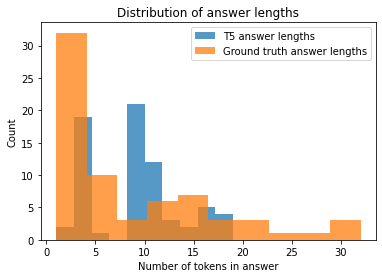

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(t5_lengths, label="T5 answer lengths", alpha=0.75)
ax.hist(gt_lengths, label="Ground truth answer lengths", alpha=0.75)
ax.set_title("Distribution of answer lengths")
ax.set_xlabel("Number of tokens in answer")
ax.set_ylabel("Count")
# ax.set_xlim(0,60)

ax.legend()
plt.savefig("LengthDistributionComparison_COVID_GQA")

# Predictions (2nd wave)

In [ ]:
import pandas as pd

sim_df = pd.read_csv(os.path.join(DATA_DIR,"active_learning", "sim_df_75.csv"))
sme_df = pd.read_csv(os.path.join(DATA_DIR,"active_learning", "sme_rule_based.csv"))
final_sim_df = pd.read_csv(os.path.join(DATA_DIR,"active_learning", "df_qa_sim_positive_labels.csv"))

In [ ]:
sme_df

In [ ]:
final_sim_df

In [ ]:
sme_df["questions"].head().tolist()

In [ ]:
%%capture

covid_predict_inputs_sim_df_path = os.path.join(MODEL_DIR, "predict_inputs_sim_df_75.txt")
covid_predict_outputs_sim_path = os.path.join(MODEL_DIR, "predict_outputs_sim_df_75.txt")
with tf.io.gfile.GFile(covid_predict_inputs_sim_df_path, "w") as f:
  for idx, row in sim_df.iterrows():
    q = row["title"]
    # print(q)
    f.write("trivia question: %s\n" % q.lower()) #TODO: can also invoke the preprocess from earlier

model.batch_size = 1024  # Min size for small model on v2-8 with parallelism 1.
model.predict(
    input_file=covid_predict_inputs_sim_df_path,
    output_file=covid_predict_outputs_sim_path,
    # Select the most probable output token at each step.
    temperature=0,
)

In [ ]:
%%capture
covid_predict_inputs_sim_df_path_new = os.path.join(MODEL_DIR, "predict_inputs_df_qa_sim_positive_labels.txt")
covid_predict_outputs_sim_df_path_new = os.path.join(MODEL_DIR, "predict_outputs_df_qa_sim_positive_labels.txt")
with tf.io.gfile.GFile(covid_predict_inputs_sim_df_path_new, "w") as f:
  for idx, row in final_sim_df.iterrows():
    q = row["question"]
    f.write("trivia question: %s\n" % q.lower()) #TODO: can also invoke the preprocess from earlier

model.batch_size = 1024  # Min size for small model on v2-8 with parallelism 1.
model.predict(
    input_file=covid_predict_inputs_sim_df_path_new,
    output_file=covid_predict_outputs_sim_df_path_new,
    # Select the most probable output token at each step.
    temperature=0,
)

In [ ]:
covid_predict_inputs_sme_path = os.path.join(MODEL_DIR, "predict_inputs_sme_rule_based.txt")
covid_predict_outputs_sme_path = os.path.join(MODEL_DIR, "predict_outputs_sme_rule_based.txt")
with tf.io.gfile.GFile(covid_predict_inputs_sme_path, "w") as f:
  for idx, row in sme_df.iterrows():
    q = row["questions"]
    print(q)
    f.write("trivia question: %s\n" % q.lower()) #TODO: can also invoke the preprocess from earlier

model.batch_size = 1024  # Min size for small model on v2-8 with parallelism 1.
model.predict(
    input_file=covid_predict_inputs_sme_path,
    output_file=covid_predict_outputs_sme_path,
    # Select the most probable output token at each step.
    temperature=0,
)

In [ ]:
print("OK")

In [ ]:
# tying together predictions from both

In [ ]:
a = 10
while True:
  a = 2


In [ ]:
covid_predict_outputs_sme_path + "-1025700"

'gs://t5-open-qa-bucket/models/large/predict_outputs_sme_rule_based.txt-1025700'

In [ ]:
# we need a google cloud read!

In [ ]:
with tf.io.gfile.GFile((covid_predict_outputs_sme_path + "-1025700")) as answers, tf.io.gfile.GFile((covid_predict_inputs_sme_path )) as questions:
  list_answers = answers.readlines()
  list_questions = questions.readlines()
  sme_df = pd.DataFrame(data={"questions":list_questions , "answers": list_answers} )
  # print(len(), len(questions.readlines()))

    
    #

In [ ]:
sme_df

,questions,answers
0,trivia question: how domain growth is implemen...,how genes are transferred between different po...
1,trivia question: how to make more from exposur...,machine learning and pathogen exposure risk mi...
2,trivia question: when will the battle against ...,"january 3, 2018\n"
3,trivia question: how to differentiate covid-19...,the ct imaging method is a technique that can ...
4,trivia question: how does the outbreak of 2019...,from respiratory droplets that become airborne...
...,...,...
605,trivia question: the ethics of improving afric...,african traditional research methods\n
606,trivia question: are formyl peptide receptors ...,formyl peptide receptors (fprs) are a class of...
607,trivia question: minireview new agents modulat...,there is a growing body of evidence that sugge...
608,trivia question: pentraxins and collectins: fr...,a key player in the pathogen-host relationship\n


In [ ]:
covid_predict_inputs_sim_df_path_new
covid_predict_outputs_sim_df_path_new

'gs://t5-open-qa-bucket/models/large/predict_outputs_df_qa_sim_positive_labels.txt'

In [ ]:
with tf.io.gfile.GFile((covid_predict_outputs_sim_df_path_new + "-1025700")) as answers, tf.io.gfile.GFile((covid_predict_inputs_sim_df_path_new )) as questions:
  list_answers = answers.readlines()
  list_questions = questions.readlines()
  new_sim_df = pd.DataFrame(data={"questions":list_questions , "answers": list_answers} )
  # print(len(), len(questions.readlines()))

    
    #

In [ ]:
sme_out_path = os.path.join(DATA_DIR, "sme.csv")
sim_out_path = os.path.join(DATA_DIR, "sim.csv")
new_sim_out_path = os.path.join(DATA_DIR, "new_sim.csv")

In [ ]:
sme_df.to_csv(sme_out_path)

In [ ]:
new_sim_df.to_csv(new_sim_out_path)

In [ ]:
with tf.io.gfile.GFile((covid_predict_outputs_sim_path + "-1025700")) as answers, tf.io.gfile.GFile((covid_predict_inputs_sim_df_path )) as questions:
  list_answers = answers.readlines()
  list_questions = questions.readlines()
  sim_df = pd.DataFrame(data={"questions":list_questions , "answers": list_answers} )

In [ ]:
sim_df

,questions,answers
0,trivia question: a randomized open-label trial...,"a randomized, placebo-controlled trial\n"
1,trivia question: using patient-specific induce...,we have used iPS cells to generate a knockout ...
2,trivia question: using patient-specific induce...,we have used iPS cells to generate a knockout ...
3,trivia question: using patient-specific induce...,we have used iPS cells to generate a knockout ...
4,trivia question: using patient-specific induce...,we have used iPS cells to generate a knockout ...
...,...,...
69360,trivia question: chinese journal of natural me...,chinese journal of natural medicines\n
69361,trivia question: chinese journal of natural me...,chinese journal of natural medicines\n
69362,trivia question: chinese journal of natural me...,chinese journal of natural medicines\n
69363,trivia question: chinese journal of natural me...,chinese journal of natural medicines\n


In [ ]:
sim_df.to_csv(sim_out_path)

In [ ]:
additional_COVID_QA_df["t5_answers"] = answers

In [ ]:
answers

In [ ]:
additional_COVID_QA_df

,question,text,answer,t5_answers
0,How large is the sample size used in COVID-19 ...,Of all 59 cases diagnosed as COVID-19 in the t...,59 cases,the study must have at least one adult partici...
1,What is the incubation period of the virus?,By pooling individual data from seven countrie...,7.44 days,the incubation period for most viruses range f...
2,How large is the sample size used in COVID-19 ...,"However, based on 329 cases (28.48%) with rele...",329 cases,the study must have at least one adult partici...
3,What is the incubation period of the virus?,Twenty-one patients with COVID-19 with GI symp...,4 days (IQR 3–7 days),the incubation period for most viruses range f...
4,What is the incubation period of the virus?,The median incubation period of both male and ...,The median incubation period of both male and ...,the incubation period for most viruses range f...
...,...,...,...,...
64,What is the RR for severe infection in COVID-1...,"In univariate analyses, factors robustly assoc...",diabetes (9 studies; 3.20 [2.26-4.53],rr > 0\n
65,What is the OR for severe infection in COVID-1...,There were significant correlations between CO...,There were significant correlations between CO...,septic shock\n
66,What is the OR for severe infection in COVID-1...,There were significant correlations between CO...,"[OR=2.67, 95% CI (1.91, 3.74), P<0.01]",a type 2 diabetes mellitus\n
67,What is the OR for severe infection in COVID-1...,"Arrhythmia (OR: 22.17, 95%CI 4.47-110.04), acu...","OR: 2.69, 95%CI 1.",septic shock\n


In [ ]:
additional_COVID_QA_df

,question,text,answer,t5_answers
0,How large is the sample size used in COVID-19 ...,Of all 59 cases diagnosed as COVID-19 in the t...,59 cases,the study must have at least one adult partici...
1,What is the incubation period of the virus?,By pooling individual data from seven countrie...,7.44 days,the incubation period for most viruses range f...
2,How large is the sample size used in COVID-19 ...,"However, based on 329 cases (28.48%) with rele...",329 cases,the study must have at least one adult partici...
3,What is the incubation period of the virus?,Twenty-one patients with COVID-19 with GI symp...,4 days (IQR 3–7 days),the incubation period for most viruses range f...
4,What is the incubation period of the virus?,The median incubation period of both male and ...,The median incubation period of both male and ...,the incubation period for most viruses range f...
...,...,...,...,...
64,What is the RR for severe infection in COVID-1...,"In univariate analyses, factors robustly assoc...",diabetes (9 studies; 3.20 [2.26-4.53],rr > 0\n
65,What is the OR for severe infection in COVID-1...,There were significant correlations between CO...,There were significant correlations between CO...,septic shock\n
66,What is the OR for severe infection in COVID-1...,There were significant correlations between CO...,"[OR=2.67, 95% CI (1.91, 3.74), P<0.01]",a type 2 diabetes mellitus\n
67,What is the OR for severe infection in COVID-1...,"Arrhythmia (OR: 22.17, 95%CI 4.47-110.04), acu...","OR: 2.69, 95%CI 1.",septic shock\n


In [ ]:
# compare the answers with hilary and Yoona's work
# COVID_GQA_PATH = 

In [ ]:
T5_QA_PATH = os.path.join(DATA_DIR, "T5_CORD19_cleaned_test_QA_results_df.csv")


In [ ]:
additional_COVID_QA_df.to_csv(T5_QA_PATH)

In [ ]:
# set the addtional_COVID_QA_df to be the test set only
# additional_COVID_QA_df = unique_test_df

In [ ]:
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import sys


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def get_exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def get_f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def get_fuzzy_ratio(prediction, ground_truth):
    return fuzz.ratio(normalize_answer(prediction), normalize_answer(ground_truth))



exact_match_score = 0
f1_score = 0
total = len(additional_COVID_QA_df.index)

for index, row in additional_COVID_QA_df.iterrows():
    answer = normalize_answer(str(row['answer']))
    predicted_answer = normalize_answer(str(row['t5_answers']))
    
    exact_match_score += get_exact_match_score(predicted_answer, answer)
    f1_score += get_f1_score(predicted_answer, answer)

f1_score = 100.0 * f1_score / total
exact_match_score = 100.0 * exact_match_score / total
print('F1 Score: ' + str(f1_score))
print('Exact Match Score: ' + str(exact_match_score))

F1 Score: 0.0
Exact Match Score: 0.0


In [ ]:
## T

## The New SIM

In [ ]:
df_sim_QA = os.path.join(DATA_DIR, "df_0.75_qa_dlr_positive_labels.csv") 
sme_df_new = pd.read_csv(df_sim_QA)

In [ ]:
sme_df_new

,Unnamed: 0,Unnamed: 0.1,sim_score,title,sim,Validity,question,answer,label,source
0,6,6,0.789408,Panax ginseng and Panax quinquefolius: From ph...,"Hence, pseudoknots can act as ribosomal roadbl...",0.0,What does Panax ginseng and Panax quinquefoliu...,Panax ginseng and Panax quinquefolius: From ph...,True,QA_silver
1,21,21,0.863640,Impact of Imitation Processes on the Effective...,"Collectively, these results show that filoviru...",0.0,What Processes on the Effectiveness of Ring Va...,Impact of Imitation Processes on the Effective...,True,QA_silver
2,71,71,0.755380,Technical Appendix Supplementary material incl...,HBV consists of a nucleoprotein core containin...,0.0,What Technical Appendix Supplementary material...,Technical Appendix Supplementary material incl...,True,QA_silver
3,77,77,0.784730,Turkish Journal of Medical Sciences Viral prev...,"Therefore, we screened anti-HSV-1 peptides fro...",1.0,What scores are used for predicting the mortal...,Turkish Journal of Medical Sciences Viral prev...,True,QA_silver
4,79,79,0.780514,Atg5 Supports Rickettsia australis Infection i...,To uncover cellular protein responses in porci...,0.0,Who australis Infection in Macrophages In Vitro?,Atg5 Supports Rickettsia australis Infection i...,True,QA_silver
...,...,...,...,...,...,...,...,...,...,...
2995,69320,69320,0.786559,Functional role of the type 1 pilus rod struct...,Ebola virus VP35 protein binds double-stranded...,0.0,What pilus rod structure in mediating host-pat...,Functional role of the type 1 pilus rod struct...,True,QA_silver
2996,69330,69330,0.776806,Delivery of steric block morpholino oligomers ...,Bovine norovirus (BNoV) has emerged as a viral...,0.0,What does delivery of steric block morpholino ...,Delivery of steric block morpholino oligomers ...,True,QA_silver
2997,69346,69346,0.790650,Virology Journal Widespread distribution and a...,IMPORTANCE A hallmark of influenza virus infec...,0.0,What did Virology Journal widespread?,Virology Journal Widespread distribution and a...,True,QA_silver
2998,69349,69349,0.762947,Epidemiology and Infection Reconstruction and ...,Ribonucleocapsids (RNCs) of negative strand RN...,0.0,What epidemics?,Epidemiology and Infection Reconstruction and ...,True,QA_silver


In [ ]:
covid_predict_inputs_sim_path_new = os.path.join(MODEL_DIR, "predict_inputs_sme_rule_based.txt")
covid_predict_outputs_sim_path_new = os.path.join(MODEL_DIR, "predict_outputs_sme_rule_based.txt")
with tf.io.gfile.GFile(covid_predict_inputs_sim_path_new, "w") as f:
  for idx, row in sme_df_new.iterrows():
    q = row["question"]
    print(q)
    f.write("trivia question: %s\n" % q.lower()) #TODO: can also invoke the preprocess from earlier

model.batch_size = 256  # Min size for small model on v2-8 with parallelism 1.
model.predict(
    input_file=covid_predict_inputs_sim_path_new,
    output_file=covid_predict_outputs_sim_path_new,
    # Select the most probable output token at each step.
    temperature=0,
)

What does Panax ginseng and Panax quinquefolius: From to toxicology?
What Processes on the Effectiveness of Ring Vaccination NIH Public Access Author Manuscript?
What Technical Appendix Supplementary material including?
What scores are used for predicting the mortality of adults with severe acute respiratory infections?
Who australis Infection in Macrophages In Vitro?
What is rNA disruption associated with in tumor cell lines?
Who does Mus musculus?
What does necrotizing enteritis Caused by Pharyngostomum cordatum Infection in?
What nanoclusters for sensitively simultaneous detection of two HIV DNAs?
What did copious production of SARS-CoV nucleocapsid protein employing codon optimize?
Who endomembrane recruitment for plant RNA virus replication?
What enhances interferon-y-mediated class II antigen expression on astrocytes?
What facilitates viral spread and transmission by its insect vector?
What does pER1 prevent excessive innate immune response during endotoxin-induced liver injury t

In [ ]:
with tf.io.gfile.GFile((covid_predict_outputs_sim_path_new + "-1025700")) as answers, tf.io.gfile.GFile((covid_predict_inputs_sim_path_new )) as questions:
  list_answers = answers.readlines()
  list_questions = questions.readlines()
  sim_df_new = pd.DataFrame(data={"questions":list_questions , "answers": list_answers} )

In [ ]:
RESULTS_DIR = os.path.join(BASE_DIR, "results")

In [ ]:
RESULTS_DIR

'gs://t5-open-qa-bucket/results'

In [ ]:
RESULTS_DIR + "sim_df_new.csv"

'gs://t5-open-qa-bucket/resultssim_df_new.csv'

In [ ]:
sim_df_new.to_csv(os.path.join(RESULTS_DIR , "sim_df_new.csv"))

# Predict on Manually annotated Valid Examples

In [ ]:
valid_annotated_df["questions"].head().tolist()

['What scores are used for predicting the mortality of adults with severe acute respiratory infections?',
 'What is rNA disruption associated with in tumor cell lines?',
 'What nanoclusters for sensitively simultaneous detection of two HIV DNAs?',
 'What did copious production of SARS-CoV nucleocapsid protein employing codon optimize?',
 'What enhances interferon-y-mediated class II antigen expression on astrocytes?']

In [ ]:
covid_predict_manual_valid_inputs_path = os.path.join(MODEL_DIR, "predict_inputs_manual_df.txt")
covid_predict_manual_valid_outputs_path = os.path.join(MODEL_DIR, "predict_outputs_manual_df.txt")
with tf.io.gfile.GFile(covid_predict_manual_valid_inputs_path, "w") as f:
  for idx, row in valid_annotated_df.iterrows():
    q = row["questions"]
    print(q)
    f.write("trivia question: %s\n" % q.lower()) #TODO: can also invoke the preprocess from earlier

model.batch_size = 256  # Min size for small model on v2-8 with parallelism 1.
model.predict(
    input_file=covid_predict_manual_valid_inputs_path,
    output_file=covid_predict_manual_valid_outputs_path,
    # Select the most probable output token at each step.
    temperature=0,
)

What scores are used for predicting the mortality of adults with severe acute respiratory infections?
What is rNA disruption associated with in tumor cell lines?
What nanoclusters for sensitively simultaneous detection of two HIV DNAs?
What did copious production of SARS-CoV nucleocapsid protein employing codon optimize?
What enhances interferon-y-mediated class II antigen expression on astrocytes?
What facilitates viral spread and transmission by its insect vector?
What does pER1 prevent excessive innate immune response during endotoxin-induced liver injury through?
What did Immunogenicity of the S protein of transmissible gastroenteritis virus express in?
What prevents roach-allergic asthma in a murine model?
What is canine distemper virus-induced depletion of uninfected lymphocytes associated with?
What directs retrograde transsynaptic transport among neurons in vivo?
What reveals that the anti-cancer target Ubiquitin-Specific Protease 17 is a highly efficient deubiquitinating enzym

In [ ]:
with tf.io.gfile.GFile((covid_predict_manual_valid_outputs_path + "-1025700")) as answers, tf.io.gfile.GFile((covid_predict_manual_valid_inputs_path )) as questions:
  list_answers = answers.readlines()
  list_questions = questions.readlines()
  final_manual_valid_df = pd.DataFrame(data={"questions":list_questions , "answers": list_answers} )
  # print(len(), len(questions.readlines()))

    
    #

In [ ]:
T5_MANUAL_QA_PATH = os.path.join(DATA_DIR, "T5_MANUAL_QA.csv")


In [ ]:
final_manual_valid_df.to_csv(T5_MANUAL_QA_PATH)


# More Annotate and Predict, and Compute Exact Matches

In [ ]:
more_annotated_path = os.path.join(DATA_DIR, "df_0.75_qa_dlr_positive_labels.csv") 
more_annotated_df = pd.read_csv(more_annotated_path)


In [ ]:
more_annotated_df.head()

,Unnamed: 0,Unnamed: 0.1,sim_score,title,sim,Validity,question,answer,label,source
0,6,6,0.789408,Panax ginseng and Panax quinquefolius: From ph...,"Hence, pseudoknots can act as ribosomal roadbl...",0.0,What does Panax ginseng and Panax quinquefoliu...,Panax ginseng and Panax quinquefolius: From ph...,True,QA_silver
1,21,21,0.863640,Impact of Imitation Processes on the Effective...,"Collectively, these results show that filoviru...",0.0,What Processes on the Effectiveness of Ring Va...,Impact of Imitation Processes on the Effective...,True,QA_silver
2,71,71,0.755380,Technical Appendix Supplementary material incl...,HBV consists of a nucleoprotein core containin...,0.0,What Technical Appendix Supplementary material...,Technical Appendix Supplementary material incl...,True,QA_silver
3,77,77,0.784730,Turkish Journal of Medical Sciences Viral prev...,"Therefore, we screened anti-HSV-1 peptides fro...",1.0,What scores are used for predicting the mortal...,Turkish Journal of Medical Sciences Viral prev...,True,QA_silver
4,79,79,0.780514,Atg5 Supports Rickettsia australis Infection i...,To uncover cellular protein responses in porci...,0.0,Who australis Infection in Macrophages In Vitro?,Atg5 Supports Rickettsia australis Infection i...,True,QA_silver


In [ ]:
valid_more_annotated_df = more_annotated_df[more_annotated_df["Validity"]==1]

In [ ]:
%%time
# we need a summary statistics, like length, n-gram counts etc.
covid_predict_dlr_manual_valid_inputs_path = os.path.join(MODEL_DIR, "df_075_qa_dlr_positive_labels_inputs.txt")
covid_predict_dlr_manual_valid_outputs_path = os.path.join(MODEL_DIR, "df_075_qa_dlr_positive_labels_outputs.txt")
with tf.io.gfile.GFile(covid_predict_dlr_manual_valid_inputs_path, "w") as f:
  for idx, row in valid_more_annotated_df.iterrows():
    q = row["question"]
    f.write("trivia question: %s\n" % q.lower()) #TODO: can also invoke the preprocess from earlier

model.batch_size = 512  # Min size for small model on v2-8 with parallelism 1.
model.predict(
    input_file=covid_predict_dlr_manual_valid_inputs_path,
    output_file=covid_predict_dlr_manual_valid_outputs_path,
    # Select the most probable output token at each step.
    temperature=0,
)

INFO:tensorflow:Using config: {'_model_dir': 'gs://t5-open-qa-bucket/models/large', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.60.63.218:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['10.60.63.218:8470']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.60.63.218:8470', '_evaluation_master': 'grpc://10.60.63.218:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replica

In [ ]:
with tf.io.gfile.GFile((covid_predict_dlr_manual_valid_outputs_path + "-1025700")) as answers, tf.io.gfile.GFile((covid_predict_dlr_manual_valid_inputs_path )) as questions:
  list_answers = answers.readlines()
  list_questions = questions.readlines()
  dlr_manual_df = pd.DataFrame(data={"questions":list_questions , "answers": list_answers} )
  # print(len(), len(questions.readlines()))

    
    #

In [ ]:
dlr_manual_df

,questions,answers
0,trivia question: what scores are used for pred...,ebola score\n
1,trivia question: what is rna disruption associ...,apoptosis\n
2,trivia question: what nanoclusters for sensiti...,chimeric nanoclusters\n
3,trivia question: what did copious production o...,sars-cov nucleocapsid protein folding into a t...
4,trivia question: what enhances interferon-y-me...,activin\n
...,...,...
1413,trivia question: what induces chemokine rantes...,irf-3 is a transcription factor involved in th...
1414,trivia question: what identifies novel cis-reg...,dna fingerprinting\n
1415,trivia question: what did recombinant rotaviru...,a mechanism of action\n
1416,trivia question: what counteracts bst2 restric...,bcl-2\n


In [ ]:
valid_more_annotated_df["t5_answers"] = list_answers

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
valid_more_annotated_df.to_csv(os.path.join(BASE_DIR,"results","QA_SILVER_DUAL_ANSWERS.CSV"))

In [ ]:
valid_more_annotated_df


,Unnamed: 0,Unnamed: 0.1,sim_score,title,sim,Validity,question,answer,label,source,t5_answers
3,77,77,0.784730,Turkish Journal of Medical Sciences Viral prev...,"Therefore, we screened anti-HSV-1 peptides fro...",1.0,What scores are used for predicting the mortal...,Turkish Journal of Medical Sciences Viral prev...,True,QA_silver,ebola score\n
5,86,86,0.816880,RNA disruption is associated with response to ...,The structure and synthesis of bovine coronavi...,1.0,What is rNA disruption associated with in tumo...,RNA disruption is associated with response to ...,True,QA_silver,apoptosis\n
8,214,214,0.802514,DNA-programming multicolor silver nanoclusters...,Objective To assess the utility of a panviral ...,1.0,What nanoclusters for sensitively simultaneous...,DNA-programming multicolor silver nanoclusters...,True,QA_silver,chimeric nanoclusters\n
9,274,274,0.800601,Copious production of SARS-CoV nucleocapsid pr...,The monoclonal antibodies used were directed a...,1.0,What did copious production of SARS-CoV nucleo...,Copious production of SARS-CoV nucleocapsid pr...,True,QA_silver,sars-cov nucleocapsid protein folding into a t...
11,293,293,0.785230,Tumor necrosis factor-a enhances interferon-y-...,The clinical diagnosis was confirmed by serolo...,1.0,What enhances interferon-y-mediated class II a...,Tumor necrosis factor-a enhances interferon-y-...,True,QA_silver,activin\n
...,...,...,...,...,...,...,...,...,...,...,...
2953,68181,68181,0.756056,Tick-borne encephalitis virus induces chemokin...,Overnutrition Aggravates Childhood Respiratory...,1.0,What induces chemokine RANTES expression via a...,Tick-borne encephalitis virus induces chemokin...,True,QA_silver,irf-3 is a transcription factor involved in th...
2958,68285,68285,0.851834,Positional clustering improves computational b...,The MERS-CoV S nanoparticle vaccine produced h...,1.0,What identifies novel cis-regulatory sites in ...,Positional clustering improves computational b...,True,QA_silver,dna fingerprinting\n
2966,68586,68586,0.784935,Recombinant rotaviruses rescued by reverse gen...,Bats in the EU have been associated with sever...,1.0,What did recombinant rotaviruses rescue by rev...,Recombinant rotaviruses rescued by reverse gen...,True,QA_silver,a mechanism of action\n
2968,68638,68638,0.847733,Japanese encephalitis virus counteracts BST2 r...,In this mini review we discuss type III IFN si...,1.0,What counteracts BST2 restriction via its enve...,Japanese encephalitis virus counteracts BST2 r...,True,QA_silver,bcl-2\n


In [ ]:
lengths = [len(seq.split()) for seq in list_answers]

In [ ]:
# lengths
import nltk
import matplotlib.pyplot as plt


In [ ]:
# tokenized

In [ ]:
tokenized = ' '.join(list_answers).lower().split()
fdist = nltk.FreqDist(tokenized)

In [ ]:
top_tokens = fdist.most_common(15)
D = dict(top_tokens)


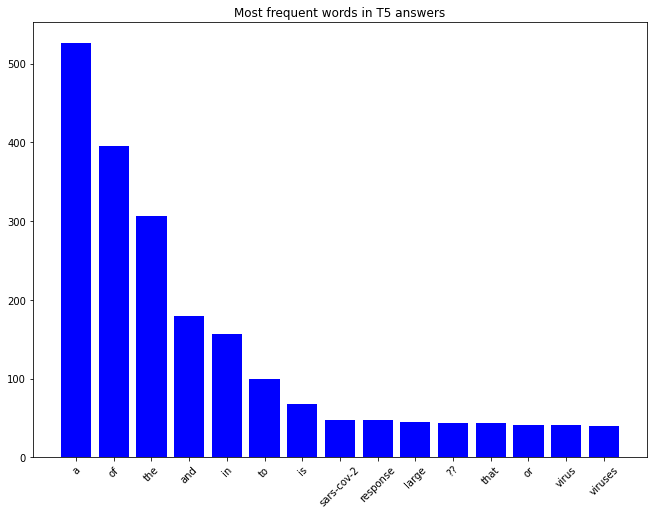

In [ ]:
# ax.bar(
fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(11,8)

ax.bar(range(len(D)), list(D.values()), align='center', color='b')
ax.set_xticks(range(len(D)), )
ax.set_xticklabels(list(D.keys()),rotation=45)
# deprecated in favour of xticks 
ax.set_title("Most frequent words in T5 answers")
plt.savefig("T5 answers")

In [ ]:
# fig

In [ ]:

# import io
# buf = io.BytesIO()
# plt.savefig(buf, format='png')


In [ ]:

# buf.seek(0)

In [ ]:

tokenized = ' '.join(valid_more_annotated_df["answer"].tolist()).lower().split()

fdist = nltk.FreqDist(tokenized)
top_tokens = fdist.most_common(15)
D = dict(top_tokens)


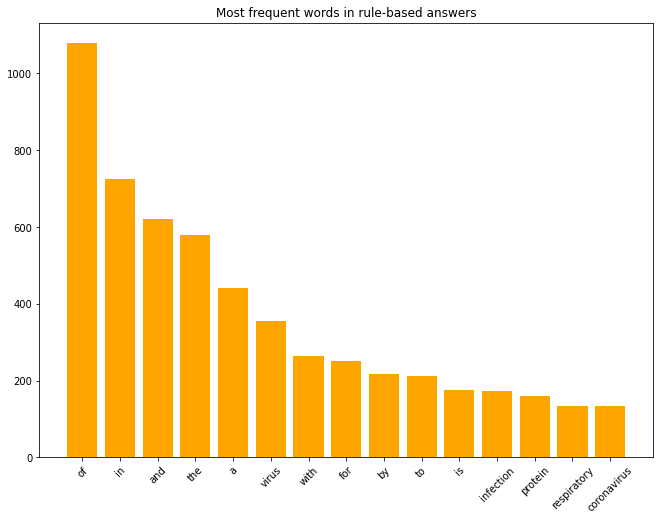

In [ ]:
# ax.bar(
fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(11,8)
ax.bar(range(len(D)), list(D.values()), align='center', color="orange")
ax.set_xticks(range(len(D)), )
ax.set_xticklabels(list(D.keys()),rotation=45)
ax.set_title("Most frequent words in rule-based answers")
plt.savefig("Rule based answers")


In [ ]:
# top_tokens

In [ ]:
plt.savefig("Rule based answers")

<Figure size 432x288 with 0 Axes>

In [ ]:
# plt.setp(xtickNames, rotation=45, fontsize=8)

In [ ]:
# fig

In [ ]:
fdist.values()

dict_values([1, 13, 1078, 4, 1, 114, 1, 20, 13, 620, 6, 12, 1, 251, 3, 578, 6, 8, 263, 33, 57, 135, 34, 74, 2, 175, 70, 48, 212, 17, 1, 1, 8, 725, 8, 78, 4, 1, 1, 3, 1, 1, 1, 49, 23, 1, 2, 1, 32, 33, 13, 161, 1, 4, 1, 6, 34, 3, 1, 21, 1, 6, 7, 10, 55, 72, 4, 18, 27, 32, 218, 440, 5, 356, 5, 10, 16, 29, 5, 6, 1, 9, 2, 21, 49, 57, 1, 6, 10, 28, 5, 7, 8, 61, 8, 11, 25, 24, 6, 5, 8, 2, 55, 5, 1, 1, 1, 10, 1, 1, 50, 1, 8, 24, 33, 10, 1, 10, 4, 1, 4, 21, 5, 4, 6, 26, 1, 1, 1, 5, 12, 6, 16, 1, 2, 7, 9, 28, 1, 11, 1, 18, 1, 16, 15, 4, 9, 1, 1, 3, 7, 14, 9, 12, 46, 135, 2, 3, 7, 18, 1, 6, 3, 2, 1, 20, 14, 19, 6, 60, 14, 10, 8, 33, 1, 1, 1, 66, 18, 1, 1, 3, 1, 172, 81, 2, 1, 20, 1, 3, 1, 38, 1, 15, 15, 4, 14, 1, 4, 4, 13, 4, 1, 1, 7, 5, 1, 3, 2, 4, 6, 7, 1, 3, 9, 1, 2, 18, 3, 1, 5, 3, 1, 1, 3, 2, 3, 4, 1, 7, 4, 9, 3, 2, 4, 1, 20, 42, 1, 10, 1, 4, 9, 11, 6, 2, 115, 3, 9, 56, 13, 6, 8, 20, 4, 6, 28, 11, 29, 21, 27, 7, 8, 2, 3, 17, 1, 67, 96, 11, 13, 8, 2, 6, 9, 11, 30, 2, 17, 1, 3, 1, 6, 2, 2, 65,

## Length-Frequency distributions

In [ ]:
transformer_lengths = [len(seq.split()) for seq in list_answers]
rule_based_lengths = [len(valid_ans.split()) for valid_ans in valid_more_annotated_df["answer"].tolist()]


In [ ]:
# transformer_lengths
# transformer_lengths =  nltk.FreqDist(' '.join(valid_more_annotated_df["t5_answers"].tolist()).lower().split())
# rule_based_lengths = nltk.FreqDist(' '.join(valid_more_annotated_df["answer"].tolist()).lower().split())

In [ ]:
# dict(transformer_lengths.most_common()).values()

In [ ]:
# rule_based_lengths

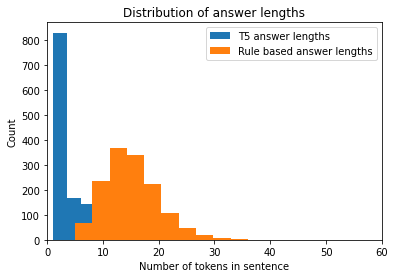

In [ ]:
fig, ax = plt.subplots()
ax.hist(transformer_lengths, label="T5 answer lengths")
ax.hist(rule_based_lengths, label="Rule based answer lengths")
ax.set_title("Distribution of answer lengths")
ax.set_xlabel("Number of tokens in sentence")
ax.set_ylabel("Count")
ax.set_xlim(0,60)

ax.legend()
plt.savefig("LengthDistributionComparison")

In [ ]:
list(dict(rule_based_lengths.most_common()).values())

[1078,
 725,
 620,
 578,
 440,
 356,
 263,
 251,
 218,
 212,
 175,
 172,
 161,
 135,
 135,
 125,
 115,
 114,
 96,
 95,
 87,
 81,
 78,
 76,
 74,
 72,
 70,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 57,
 57,
 56,
 55,
 55,
 50,
 50,
 49,
 49,
 48,
 47,
 47,
 46,
 46,
 42,
 41,
 40,
 38,
 38,
 37,
 35,
 34,
 34,
 34,
 34,
 33,
 33,
 33,
 33,
 33,
 33,
 32,
 32,
 31,
 31,
 30,
 30,
 30,
 30,
 30,
 29,
 29,
 29,
 29,
 29,
 29,
 28,
 28,
 28,
 28,
 28,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 26,
 26,
 25,
 25,
 25,
 24,
 24,
 24,
 24,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 22,
 22,
 22,
 22,
 22,
 21,
 21,
 21,
 21,
 21,
 21,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 

In [ ]:
# rule_based_lengths = [len(valid_ans.split()) for valid_ans in valid_more_annotated_df["answer"].tolist()]


## Compute some summary statistics

In [ ]:
(valid_more_annotated_df["answer"] == valid_more_annotated_df["t5_answers"]).sum()

0

In [ ]:
!pip install fuzzywuzzy

In [ ]:
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import sys


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def get_exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def get_fuzzy_ratio(prediction, ground_truth):
    return fuzz.ratio(normalize_answer(prediction), normalize_answer(ground_truth))






exact_match_score = 0
total = len(valid_more_annotated_df.index)
fuzzy_match_score = 0
for index, row in valid_more_annotated_df.iterrows():
    answer = normalize_answer(str(row['answer']))
    predicted_answer = normalize_answer(str(row['t5_answers']))
    
    exact_match_score += get_exact_match_score(predicted_answer, answer)
    fuzzy_match_score += get_fuzzy_ratio(predicted_answer, answer)

exact_match_score = 100.0 * exact_match_score / total
fuzzy_match_score  /= total

print('Exact Match Score: ' + str(exact_match_score))
print('Fuzzy Match Score: ' + str(fuzzy_match_score))

# predicted_answer

Exact Match Score: 0.0
Fuzzy Match Score: 19.585331452750353


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
corpus = valid_more_annotated_df["answer"].tolist() +  valid_more_annotated_df["t5_answers"].tolist()

In [ ]:
# preprocess corpus
preprocessed_corpus = [normalize_answer(elt) for elt in corpus]

In [ ]:
X = vectorizer.fit_transform(preprocessed_corpus)

In [ ]:
X

<2836x5982 sparse matrix of type '<class 'numpy.int64'>'
	with 25248 stored elements in Compressed Sparse Row format>

In [ ]:
t5_answers_bow = vectorizer.transform(valid_more_annotated_df["t5_answers"].tolist())

In [ ]:
reg_answers_bow = vectorizer.transform(valid_more_annotated_df["answer"].tolist())


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_sims = cosine_similarity(t5_answers_bow,reg_answers_bow)

In [ ]:
cosine_sims.shape

(1418, 1418)

In [ ]:
cosine_sims.sum()/(1/2*cosine_sims.shape[0]**2)

0.06936564385172654

In [ ]:
from fuzzywuzzy import fuzz


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# use a join, on the question = questions
# or simply, append the column at the end!
pd.concat([valid_more_annotated_df,dlr_manual_df], axis=1)

,Unnamed: 0,Unnamed: 0.1,sim_score,title,sim,Validity,question,answer,label,source,questions,answers
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trivia question: what scores are used for pred...,ebola score\n
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trivia question: what is rna disruption associ...,apoptosis\n
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trivia question: what nanoclusters for sensiti...,chimeric nanoclusters\n
3,77.0,77.0,0.784730,Turkish Journal of Medical Sciences Viral prev...,"Therefore, we screened anti-HSV-1 peptides fro...",1.0,What scores are used for predicting the mortal...,Turkish Journal of Medical Sciences Viral prev...,True,QA_silver,trivia question: what did copious production o...,sars-cov nucleocapsid protein folding into a t...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trivia question: what enhances interferon-y-me...,activin\n
...,...,...,...,...,...,...,...,...,...,...,...,...
2953,68181.0,68181.0,0.756056,Tick-borne encephalitis virus induces chemokin...,Overnutrition Aggravates Childhood Respiratory...,1.0,What induces chemokine RANTES expression via a...,Tick-borne encephalitis virus induces chemokin...,True,QA_silver,NaN,NaN
2958,68285.0,68285.0,0.851834,Positional clustering improves computational b...,The MERS-CoV S nanoparticle vaccine produced h...,1.0,What identifies novel cis-regulatory sites in ...,Positional clustering improves computational b...,True,QA_silver,NaN,NaN
2966,68586.0,68586.0,0.784935,Recombinant rotaviruses rescued by reverse gen...,Bats in the EU have been associated with sever...,1.0,What did recombinant rotaviruses rescue by rev...,Recombinant rotaviruses rescued by reverse gen...,True,QA_silver,NaN,NaN
2968,68638.0,68638.0,0.847733,Japanese encephalitis virus counteracts BST2 r...,In this mini review we discuss type III IFN si...,1.0,What counteracts BST2 restriction via its enve...,Japanese encephalitis virus counteracts BST2 r...,True,QA_silver,NaN,NaN


In [ ]:
# merge answers


## Predict

Now that we have fine-tuned the model, we can feed T5 arbitrary questions and have it predict the answers!

There is a significant amount of overhead in initializing the model so this may take a few minutes to run each time even though the prediction itself is quite fast.


To avoid this overhead, you might consider exporting a `SavedModel` and running it on [Cloud ML Engine](https://cloud.google.com/ml-engine/).



In [ ]:
question_1 = "What is known about COVID-19 therapeutics?" #@param {type:"string"}
question_2 = "What is the most populous country in the world?" #@param {type:"string"}
question_3 = "Who are the 4 members of The Beatles?" #@param {type:"string"}
question_4 = "How many teeth do humans have?" #@param {type:"string"}

questions = [question_1, question_2, question_3, question_4]

now = time.time()
# Write out the supplied questions to text files.
predict_inputs_path = os.path.join(MODEL_DIR, "predict_inputs_%d.txt" % now)
predict_outputs_path = os.path.join(MODEL_DIR, "predict_outputs_%d.txt" % now)
# Manually apply preprocessing by prepending "triviaqa question:".
with tf.io.gfile.GFile(predict_inputs_path, "w") as f:
  for q in questions:
    f.write("trivia question: %s\n" % q.lower())

# Ignore any logging so that we only see the model's answers to the questions.
# with tf_verbosity_level('ERROR'):
model.batch_size = 8  # Min size for small model on v2-8 with parallelism 1.
model.predict(
    input_file=predict_inputs_path,
    output_file=predict_outputs_path,
    # Select the most probable output token at each step.
    temperature=0,
)

# The output filename will have the checkpoint appended so we glob to get 
# the latest.
prediction_files = sorted(tf.io.gfile.glob(predict_outputs_path + "*"))
print("\nPredictions using checkpoint %s:\n" % prediction_files[-1].split("-")[-1])
with tf.io.gfile.GFile(prediction_files[-1]) as f:
  for q, a in zip(questions, f):
    if q:
      print("Q: " + q)
      print("A: " + a)
      print()

INFO:tensorflow:Using config: {'_model_dir': 'gs://t5-open-qa-bucket/models/large', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.111.107.154:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['10.111.107.154:8470']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.111.107.154:8470', '_evaluation_master': 'grpc://10.111.107.154:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker

# Export Model for Serving

As mentioned in the previous section, exporting a [`SavedModel`](https://www.tensorflow.org/guide/saved_model) can be useful for improving performance during inference or allowing your model to be deployed on a variety of platforms (e.g., TFLite, TensorFlow.js, TensorFlow Serving, or TensorFlow Hub).

**Note:** we currently only support exporting a SavedModel that runs on both CPU and GPU, not TPU.

## Export SavedModel

We first export the SavedModel. We set a batch size of 1 for simplicity, but it may be more efficient to use a larger batch size if you want to handle multiple requests per call.

For 3B and 11B models the export will take approximately 30-45 minutes.

In [ ]:
export_dir = os.path.join(MODEL_DIR, "export")

model.batch_size = 1 # make one prediction per call
saved_model_path = model.export(
    export_dir,
    checkpoint_step=-1,  # use most recent
    beam_size=1,  # no beam search
    temperature=1.0,  # sample according to predicted distribution
)
print("Model saved to:", saved_model_path)

INFO:tensorflow:Using config: {'_model_dir': 'gs://t5-open-qa-bucket/models/large', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.111.107.154:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['10.111.107.154:8470']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.111.107.154:8470', '_evaluation_master': 'grpc://10.111.107.154:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker

## Load SavedModel

One way to test our model is to load it either in eager mode or a TF 1.x session so that we can repeatedly predict from the model without the overhead of loading the graph and weights each time.

We pay the overhead once here, but it shouldn't take more than a few minutes.


### Optional: Switch to GPU Runtime

Changing the runtime type to GPU in the `Runtime` menu above before loading the SavedModel will speed up inference by using the GPU instead of CPU.



In [ ]:
#@title Optional: Run this cell to re-initialize if you switched to GPU runtime.
%tensorflow_version 2.x
!pip install tensorflow-text
from google.colab import auth
auth.authenticate_user()

In [ ]:
import tensorflow as tf
import tensorflow_text  # Required to run exported model.

def load_predict_fn(model_path):
  if tf.executing_eagerly():
    print("Loading SavedModel in eager mode.")
    imported = tf.saved_model.load(model_path, ["serve"])
    return lambda x: imported.signatures['serving_default'](tf.constant(x))['outputs'].numpy()
  else:
    print("Loading SavedModel in tf 1.x graph mode.")
    tf.compat.v1.reset_default_graph()
    sess = tf.compat.v1.Session()
    meta_graph_def = tf.compat.v1.saved_model.load(sess, ["serve"], model_path)
    signature_def = meta_graph_def.signature_def["serving_default"]
    return lambda x: sess.run(
        fetches=signature_def.outputs["outputs"].name, 
        feed_dict={signature_def.inputs["input"].name: x}
    )

predict_fn = load_predict_fn(saved_model_path)

Loading SavedModel in tf 1.x graph mode.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from gs://t5-open-qa-bucket/models/large/export/1592978440/variables/variables


KeyboardInterrupt: ignored

## Predict

We can now call the predict method with different inputs each time and relatively quickly get results.

In [ ]:
def answer(question):
  return predict_fn([question])[0].decode('utf-8')

for question in ["trivia question: where is the google headquarters?",
                 "trivia question: what is the most populous country in the world?",
                 "trivia question: who are the 4 members of the beatles?",
                 "trivia question: how many teeth do humans have?"]:
    print(answer(question))

## Deploy SavedModel

You can now deploy your SavedModel for serving (e.g., with [TensorFlow Serving](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple)).